# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

In [1]:
!nvidia-smi

Wed Nov 13 21:03:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 4500 Ada Gene...    Off | 00000000:21:00.0 Off |                  Off |
| 30%   41C    P0              38W / 210W |      0MiB / 24570MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
## !pip install -qq arff2pandas

In [3]:
!pip install -q -U watermark

In [4]:
!pip install -qq -U pandas

In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,arff2pandas

Python implementation: CPython
Python version       : 3.9.20
IPython version      : 8.15.0

numpy      : 2.0.2
pandas     : 2.2.3
torch      : 2.5.1
arff2pandas: not installed



In [6]:
pip install --upgrade torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip install --upgrade numpy

In [8]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F



%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

#RANDOM_SEED = 42

Create function to set random seed for randomness splitting data and randomness initial of the model

In [9]:
def set_seed( RANDOM_SEED):
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_SEED)

In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

By the end of this tutorial, you'll learn how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

## Data



The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

The dataset is available on my Google Drive. Let's get it:

In [10]:
!pip install gdown

In [11]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

/home/lamhuutoan.nguyen/anaconda3/envs/myenv39/lib/python3.9/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /home/lamhuutoan.nguyen/projects/my_project/LSTM-GRU_Autoencoder/ECG5000.zip
100%|██████████████████████████████████████| 10.6M/10.6M [00:00<00:00, 17.0MB/s]


In [12]:
!unzip -qq ECG5000.zip  ## can not dowload unzip


/bin/bash: line 1: unzip: command not found


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # using GPU for faster computation if Cuda is available

The data comes in multiple formats. We'll load the `arff` files into Pandas data frames:

In [14]:
!pip install --upgrade numpy scipy

In [15]:


import scipy.io.arff as arff


# Load training data
with open('ECG5000_TRAIN.arff', 'r') as f:
    train_data, train_meta = arff.loadarff(f)

# Load test data
with open('ECG5000_TEST.arff', 'r') as f:
    test_data, test_meta = arff.loadarff(f)

# Convert the ARFF data to Pandas DataFrames
train = pd.DataFrame(train_data)
test = pd.DataFrame(test_data)


We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:

In [16]:
df = pd.concat([train, test])  ## combine train and test data
df = df.sample(frac=1.0) ## shuffle df (frac = 1.0 means 100%)
df.shape

(5000, 141)

In [17]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
29,0.269583,-1.673338,-3.660603,-4.507387,-4.054090,-3.255752,-2.261862,-1.781651,-1.592919,-0.852754,...,1.140805,1.209675,1.420613,1.707532,1.636137,1.407190,1.050443,1.444463,0.952517,b'1'
794,2.025958,0.560734,-1.653333,-3.020421,-4.151522,-3.831048,-2.588135,-1.755274,-1.613341,-0.715935,...,-0.144670,0.549227,0.771142,1.061624,1.855501,2.392024,2.380599,1.135916,0.828398,b'1'
1766,1.155547,-0.954194,-2.683726,-4.259843,-4.677346,-4.082651,-2.903945,-1.856965,-1.610086,-0.997453,...,1.122855,1.350233,1.438403,1.422188,0.986765,0.625971,1.137822,1.505964,0.232395,b'1'
1331,1.522125,-0.398391,-2.396430,-3.600526,-3.320434,-2.442097,-1.348978,-0.614852,-0.432144,0.231104,...,-0.756010,-0.661496,-0.309737,-0.130476,-0.366111,-0.779042,-1.250572,-0.847328,-2.153889,b'1'
2874,-0.926339,-1.537793,-1.766614,-2.069397,-2.105750,-2.199850,-2.104990,-1.891727,-1.766889,-1.359255,...,-2.191628,-2.626192,-3.300421,-3.726944,-3.805432,-3.351510,-2.457437,-2.030641,-0.905831,b'2'


We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [18]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

Next, we'll rename the last column to `target`, so its easier to reference it:

In [19]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [20]:
df['target'] = df['target'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)



## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [21]:
df.target.value_counts()

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64

Let's plot the results:

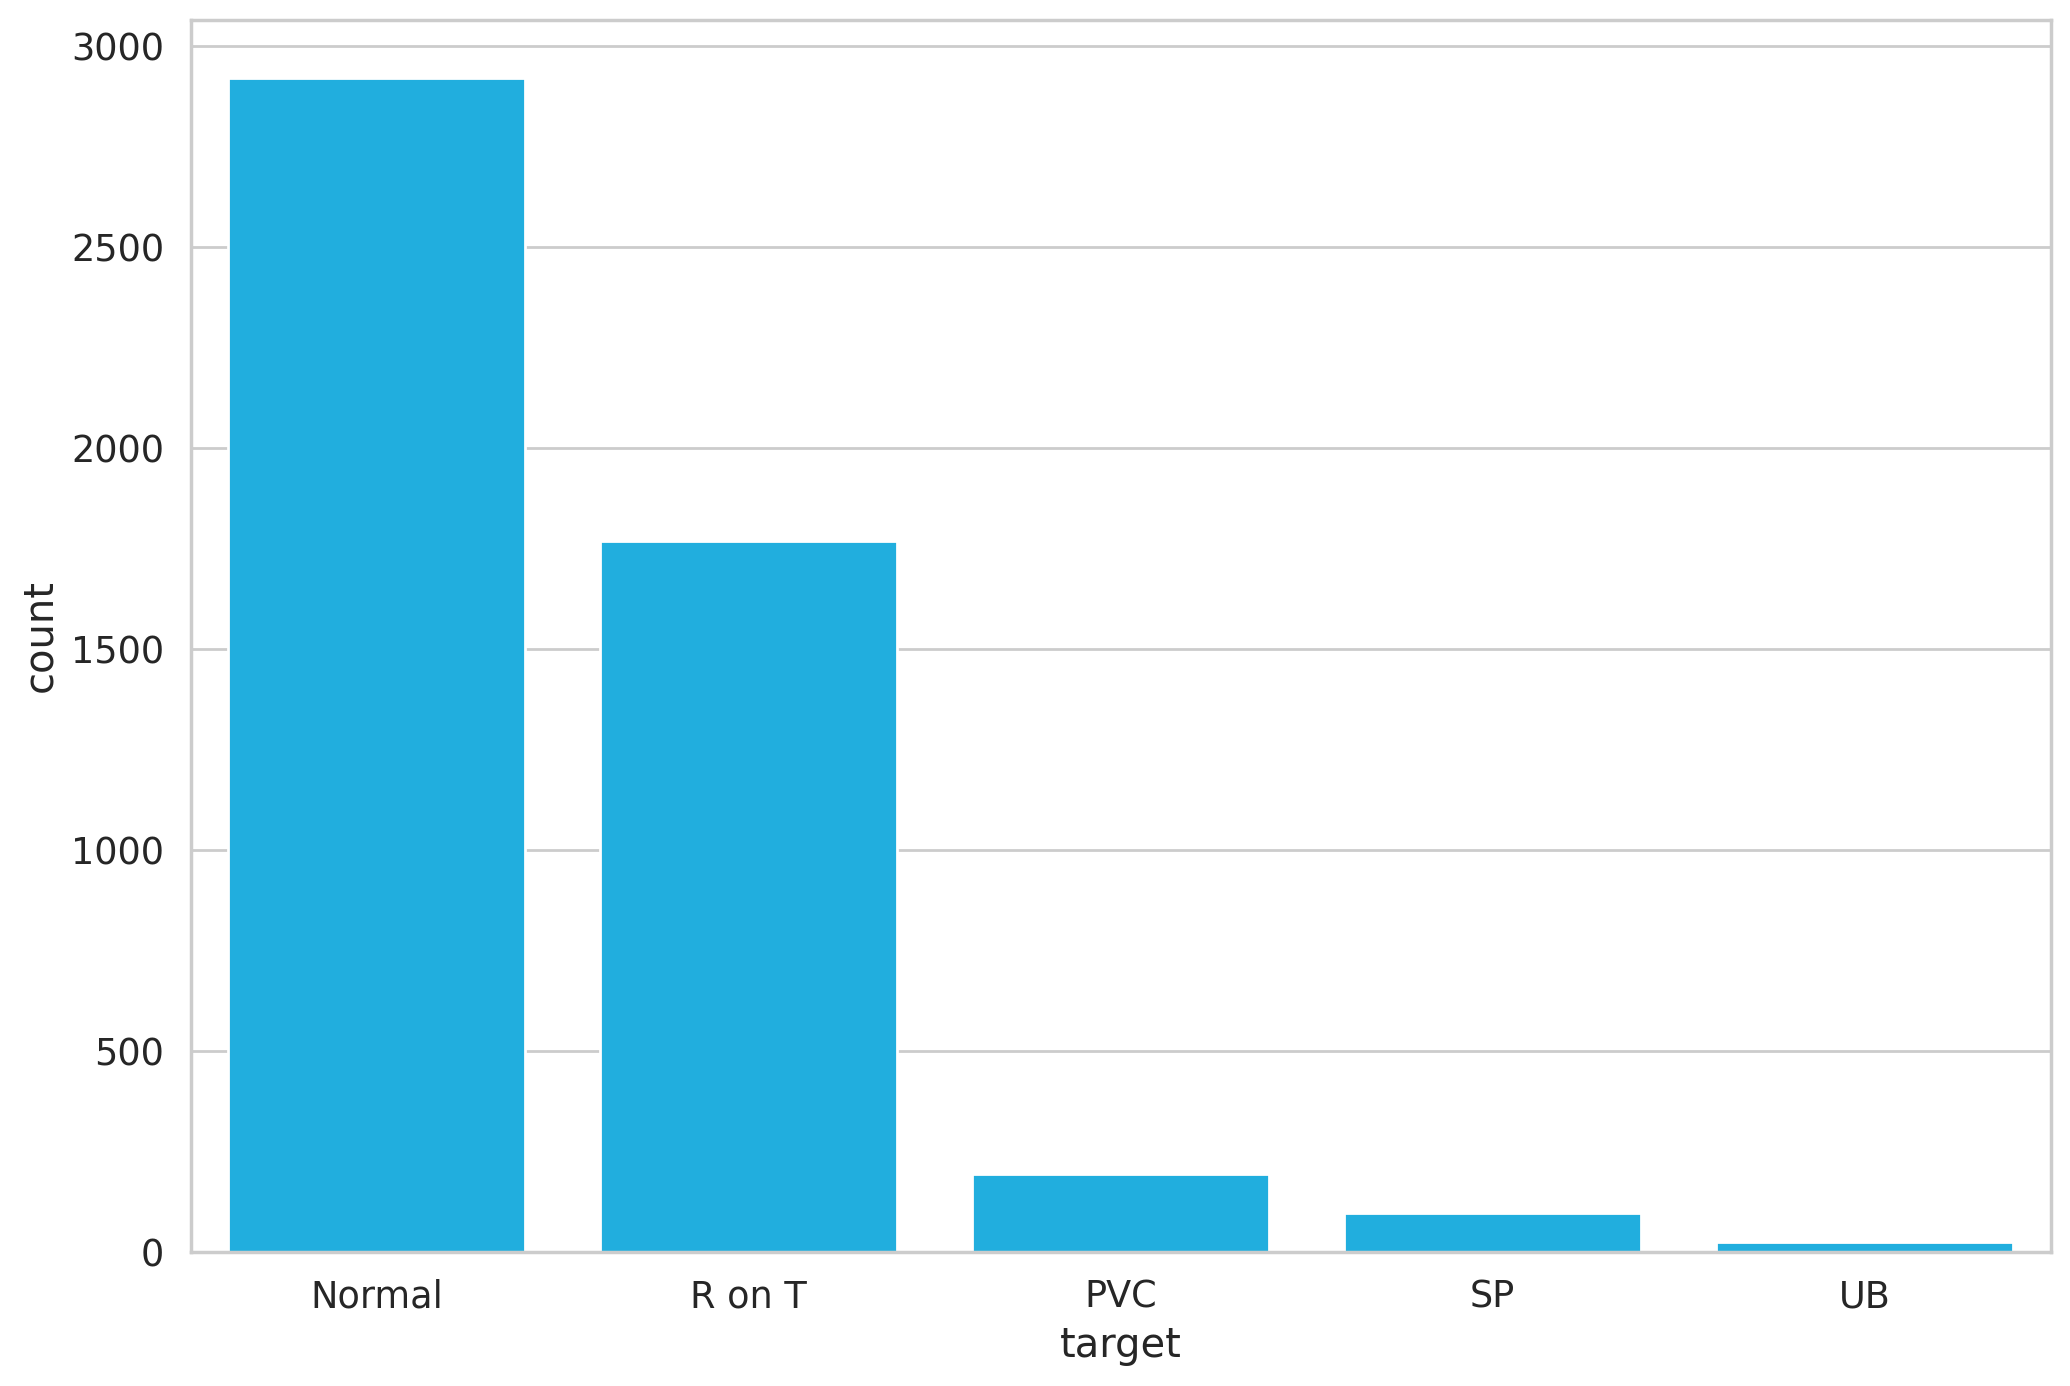

In [22]:
ax =  sns.countplot(x=df.target)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(class_names);

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [23]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

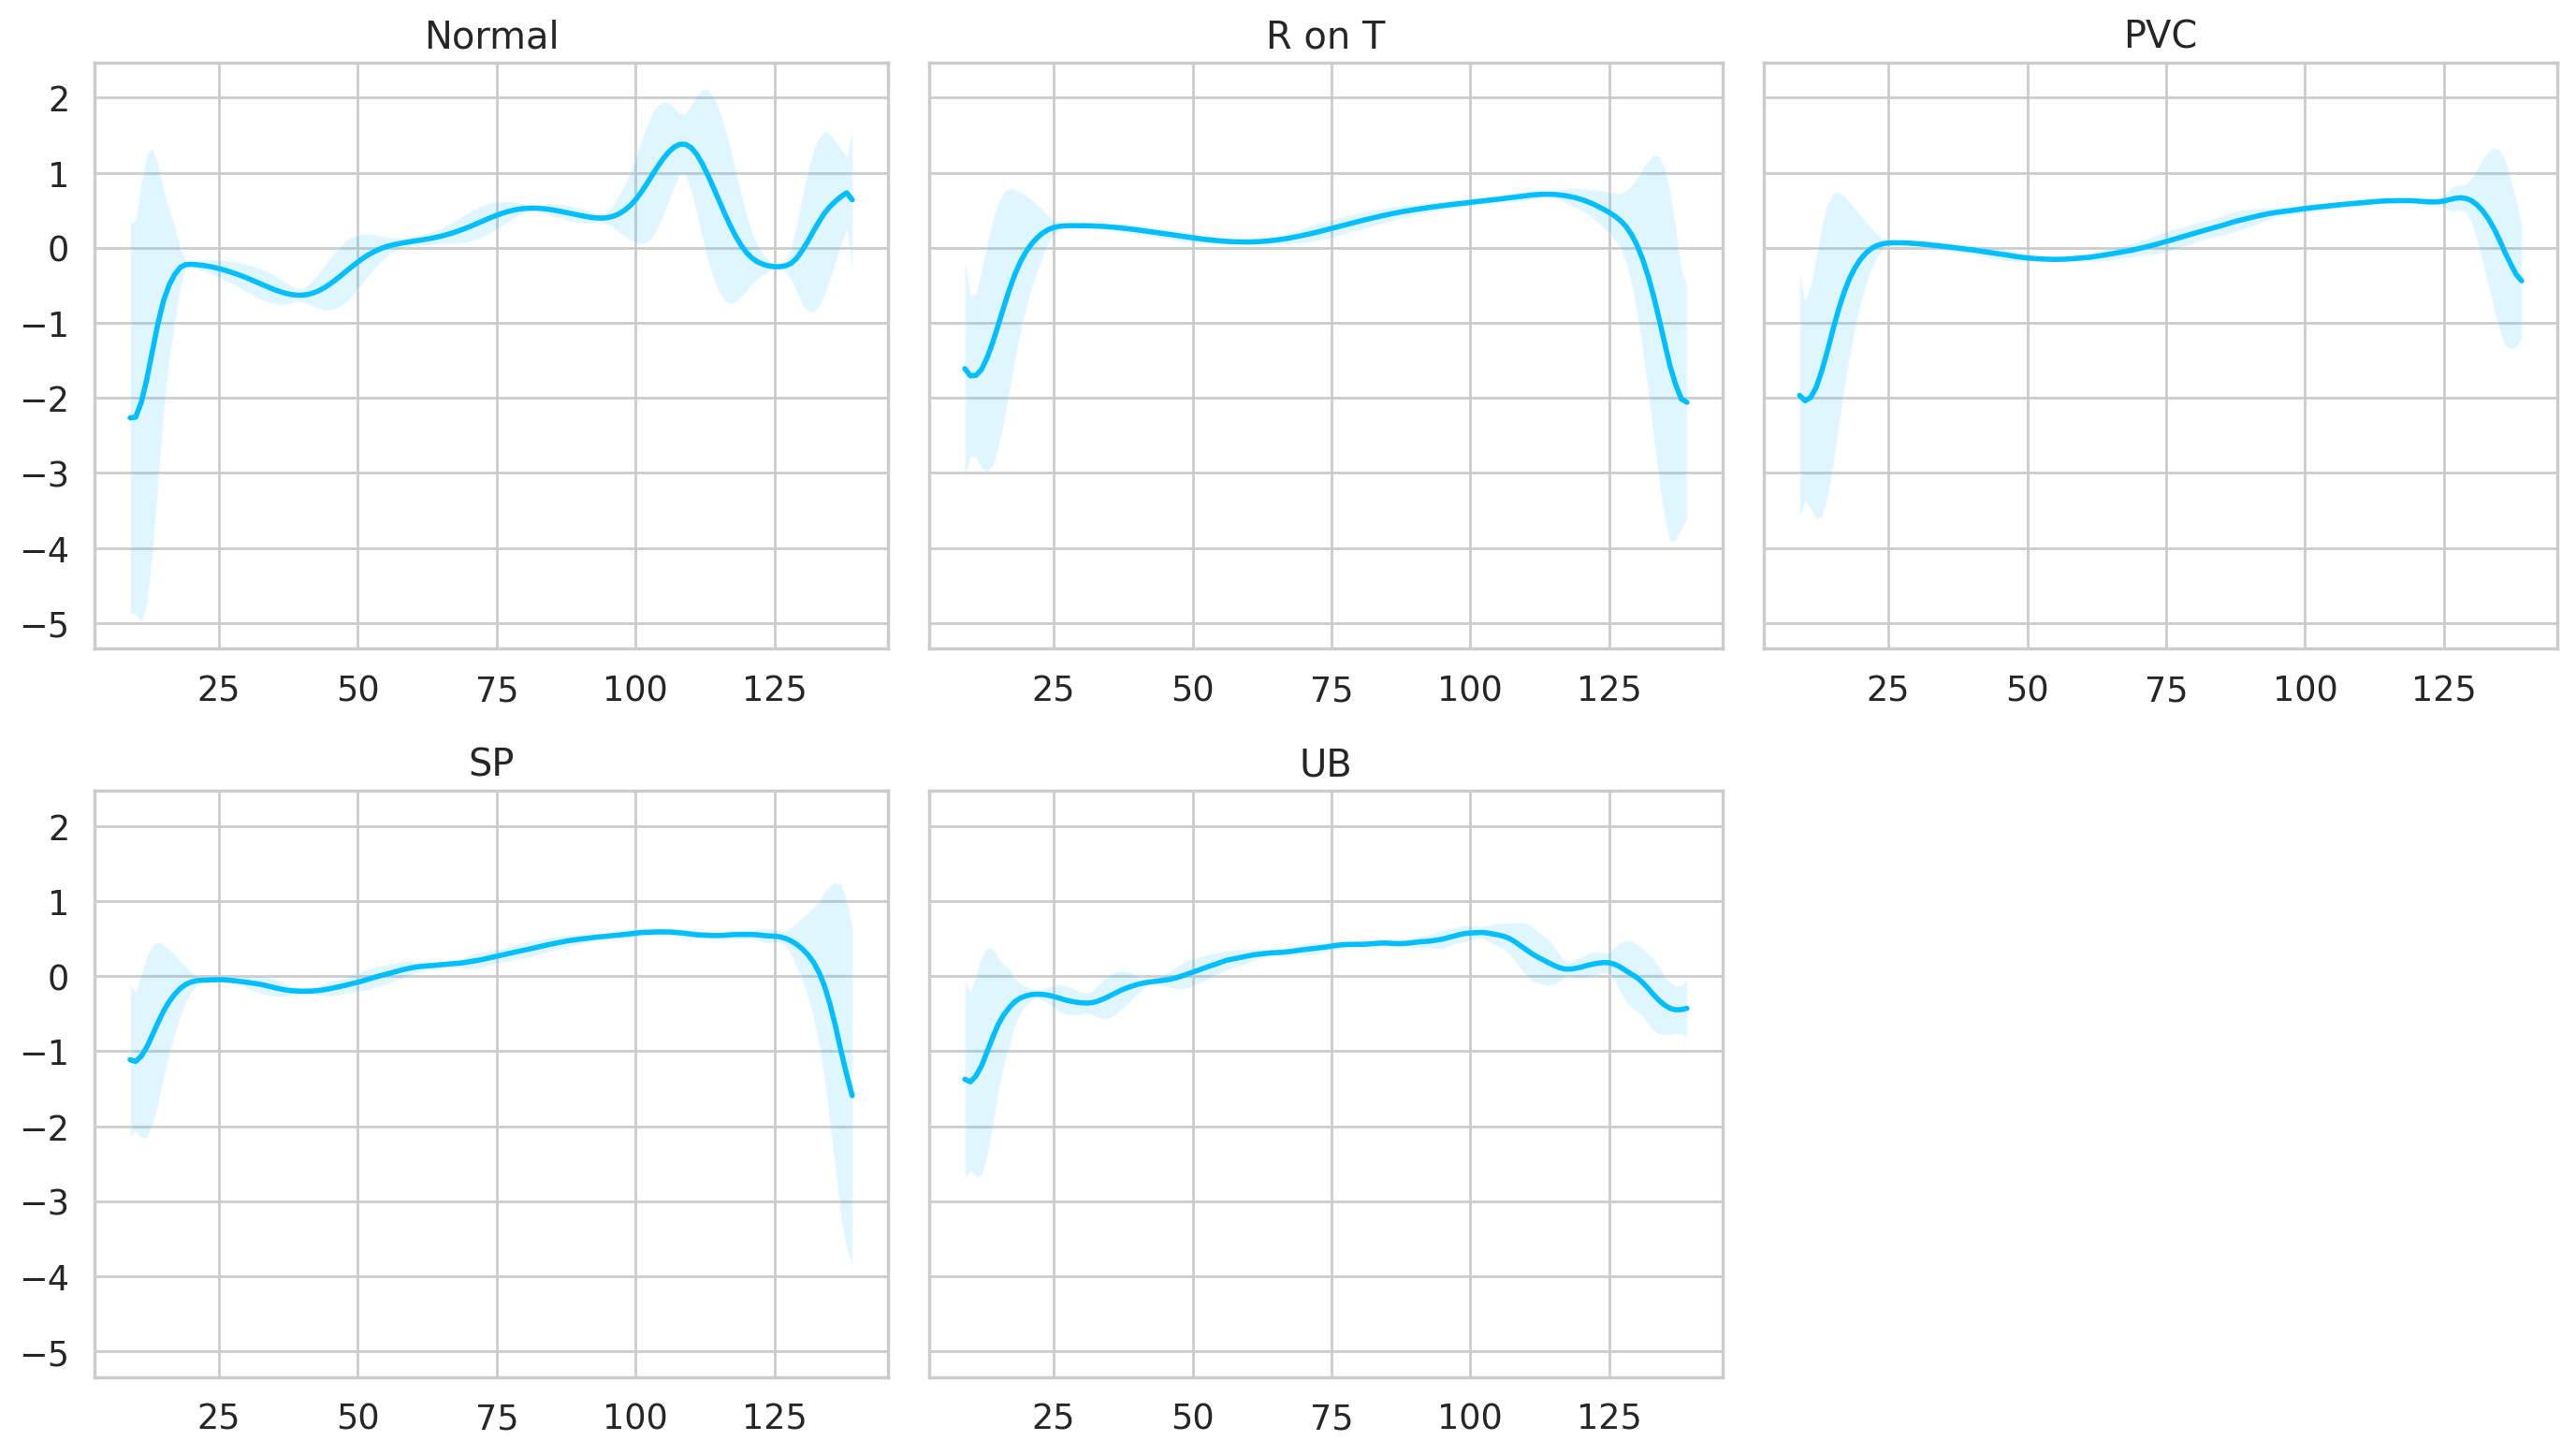

In [24]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [25]:
normal_df = df[df.target == str(CLASS_NORMAL)] #.drop(labels='target', axis=1)
#normal_target_df = df[df.target == str(CLASS_NORMAL)]['target'].copy()
normal_df.shape

(2919, 141)

We'll merge all other classes and mark them as anomalies:

In [26]:
anomaly_df = df[df.target != str(CLASS_NORMAL)] #.drop(labels='target', axis=1)
#anomaly_df_target = df[df.target != str(CLASS_NORMAL)]['target'].copy()
anomaly_df.shape

(2081, 141)

Create a function to drop the target column, but not all splited data will use this

In [27]:
def drop_target(df):
  df = df.drop(labels="target",axis =1)
  return df

We'll split the normal examples into train, validation, validation_1 and test sets:

In [28]:
def normal_train_test_val_split(RANDOM_SEED):
  S_N_df, val_df = train_test_split(
    normal_df,
    test_size=0.15,
    random_state=RANDOM_SEED
  )

  V_N_df, T_N_df = train_test_split(
    val_df,
    test_size=0.33,
    random_state=RANDOM_SEED
  )
  V_N_df, V_N1_df = train_test_split(
    V_N_df,
    test_size=0.5,
    random_state=RANDOM_SEED
  )

  S_N_df = drop_target(S_N_df)
  V_N_df = drop_target(V_N_df)
  # we dont drop_target(V_N1_df) cause we need V_N1_df_target to calculate ReErrors
  # we also need T_N_df_target to evaluate the result of our model
  return S_N_df, V_N_df, V_N1_df, T_N_df

We'll split the anomaly into validation and test sets:





In [29]:
def anomaly_val_test_split(RANDOM_SEED):
  V_A_df, T_A_df = train_test_split(
      anomaly_df,
      test_size = 0.3,
      random_state = RANDOM_SEED
  )
  #V_A_df, V_A1_df = train_test_split(
  #    V_A_df,
  #    test_size = 0.5,
  #    random_state = RANDOM_SEED
  #)
  #V_A_df = drop_target(V_A_df)
  #V_A1_df = drop_target(V_A1_df)
  
  return V_A_df, T_A_df

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [30]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

Let's create some datasets:

In [31]:
def train_val_test_val_create(S_N_df, V_N_df, V_N1_df, T_N_df, V_A_df, T_A_df):

  T_df = pd.concat([T_N_df, T_A_df]) # merge anomaly and normal test dataset
  V1_df = pd.concat([V_N1_df, V_A_df]) # merge normal validation_1 and anomaly validation dataset, this will help us to calculate the AUC
  S_N_dataset, seq_len, n_features = create_dataset(S_N_df)
  V_N_dataset, _, _ = create_dataset(V_N_df)
  

  V1_target_df = V1_df["target"] 
  V1_df = drop_target(V1_df)
  V1_dataset, _, _ = create_dataset(V1_df)
    
  T_target_df = T_df["target"]
  T_df = drop_target(T_df)
  T_dataset, _, _ = create_dataset(T_df)
  return S_N_dataset, seq_len, n_features, V_N_dataset, V1_dataset, T_dataset, V1_target_df, T_target_df




### LSTM Autoencoder

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [32]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, rnn_type, embedding_dim=64, num_stages =2):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn_type = rnn_type
    self.num_stages = num_stages
    rnn_dict = {
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

    self.rnn_stages = nn.ModuleList() # a list to hold RNN_stages but not the last stage
    
    # input_size > hidden_size, cause in Encoder we want to compress the data, reduce the dimension into a  
    # representation, which can capture the most significant features and will be passed to the decoder
    self.rnn_stages.append(  # append the first stage cause input_size = n_features
      rnn_dict[self.rnn_type.upper()](
        input_size=self.n_features,
        hidden_size=self.hidden_dim,
        num_layers=1,
        batch_first=True
      )
    )


    for i in range(1,num_stages-1): # append the rest stages except the last one
      self.rnn_stages.append(
      rnn_dict[self.rnn_type.upper()](
        input_size=self.hidden_dim, # diff from the first stage
        hidden_size=self.hidden_dim,
        num_layers=1,
        batch_first=True
      )
      )

    # self.rnn1 = rnn_dict[self.rnn_type.upper()]( #GRU
    #   input_size=self.n_features,
    #   hidden_size=self.hidden_dim,
    #   num_layers=1,
    #   batch_first=True
    # )

    self.output_stage = rnn_dict[self.rnn_type.upper()]( # the last stage
      input_size=self.hidden_dim,
      hidden_size= self.embedding_dim,
      num_layers=1,
      batch_first=True
    )

    # self.rnn2 = rnn_dict[self.rnn_type.upper()]( #GRU
    #   input_size=self.hidden_dim,
    #   hidden_size= self.embedding_dim,
    #   num_layers=1,
    #   batch_first=True
    # )




  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    if self.rnn_type.upper() == "GRU" :
      for stage in self.rnn_stages:
        x,_ = stage(x)
      x,hidden_n = self.output_stage(x)

      # x, _,  = self.rnn1(x) # x, hidden_n
      # x, hidden_n  = self.rnn2(x) # x, hidden_n
    else:
      for stage in self.rnn_stages:
        x,(_,_) = stage(x)
      x,(hidden_n,_) = self.output_stage(x)

      # x, (_,_)  = self.rnn1(x) # x, hidden_n
      # x, (hidden_n,_)  = self.rnn2(x) # x, hidden_n
    hidden_n = hidden_n[-1]

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [33]:
class Decoder(nn.Module):

  def __init__(self, seq_len, type, input_dim=64, n_features=1, num_stages =2 ):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2*input_dim, n_features
    self.rnn_type = type
    self.num_stages = num_stages


    rnn_dict = {
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }
    # input_size < hidden_size cause we want to reconstruct the original input from the passed representation
    # of the encoder
    self.rnn_stages = nn.ModuleList()
    for _ in range(num_stages -2 ):
        self.rnn_stages.append(
          rnn_dict[self.rnn_type.upper()]( #GRU
              input_size=input_dim,
              hidden_size=input_dim,
              num_layers=1,
              batch_first=True
            )
        )

    self.rnn_stages.append(rnn_dict[self.rnn_type.upper()]( #GRU
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    ))

    self.output_layer = nn.Linear(self.hidden_dim, self.n_features) # last stage

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    if self.rnn_type.upper() == "GRU" :
        for stage in self.rnn_stages:
            x, _ = stage(x)
        # x, _ = self.rnn1(x) # x, hidden_n
        # x, _ = self.rnn2(x) # x, hidden_n
    else:
        for stage in self.rnn_stages:
            x, (_,_) = stage(x)
        #x, (_, _) = self.rnn1(x)
        # x, (_, _) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [34]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, type, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features,type, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, type, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [35]:
def create_model(type,seq_len, n_features, n_stages): # we can create a LSTM-autoencoder or GRU-autoencoder
  model = RecurrentAutoencoder(seq_len, n_features, type, 128)
  model = model.to(device)
  return model

## Training

Let's write a helper function for our training process:

In [36]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true) # feed the model with the input (seq_true) to get the prediction(seq_predict)

        loss = criterion(seq_pred, seq_true) # calculate the diff between the input(seq_true)
                                            # and the predict of the model ( seq_pred)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

In [37]:
def trained_model(model, train_dataset, val_dataset, n_epochs):
  model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs
  )
  return model,history


In [38]:
#ax = plt.figure().gca()

#ax.plot(history['train'])
#ax.plot(history['val'])
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['train', 'test'])
#plt.title('Loss over training epochs')
#plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

## Saving the model

Let's store the model for later use:

In [39]:
#MODEL_PATH = 'model.pth'

#torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [40]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [41]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

Calculate the AUC_SCORE

In [42]:
def cal_AUC (target_data, pred_losses, type):
  arg = np.argsort(pred_losses) # arg[i] show the i+1 smallest lossvalue is pred_losses[arg[i]]
  rank = np.argsort(arg) # show that rank[i] is the rank of pred_losses[i]
  if type == "abnormal":
    indices = np.arange(len(target_data))[target_data != "1"]
  else:
    indices = np.arange(len(target_data))[target_data == "1"]
  n1 = len(indices)
  n2 = len(target_data) - n1
  if n1 ==0 or n2 ==0:
    print("fail")
    #raise Exception("Unable to calculate AUC score. Only elements of one class present.")
    return 0

  return (np.mean(rank[indices]) - (n1 +1)/2)/ n2

## Now we will write some scripts to run our defined funtions above

Creating the dataset with different seed 

In [43]:
def create_data(seed):
  RANDOM_SEED = set_seed(seed)
  S_N_df, V_N_df, V_N1_df, T_N_df = normal_train_test_val_split(RANDOM_SEED) 
  V_A_df, T_A_df = anomaly_val_test_split(RANDOM_SEED)
  S_N_dataset, seq_len, n_features, V_N_dataset, V1_dataset, T_dataset, V1_target_df, T_target_df  = train_val_test_val_create(S_N_df, V_N_df, V_N1_df, T_N_df, V_A_df, T_A_df)
  
  return S_N_dataset, seq_len, n_features, V_N_dataset, V1_dataset, T_dataset, V1_target_df, T_target_df


Get the model after training 

In [44]:
def get_model(type,seq_len,n_features, S_N_dataset, V_N_dataset,n_epochs, n_stages):
    model = create_model(type,seq_len, n_features, n_stages) # create model 
    model,history = trained_model(model, S_N_dataset, V_N_dataset,n_epochs) # train model
    return model    

Caculate the AUC for each model and dataset, also save the Reconstruction Errors

In [45]:
def AUC_and_predLoss(type,seq_len,n_features, S_N_dataset, V_N_dataset, V1_dataset, V1_target_df, n_epochs,n_stages):
  model = get_model(type,seq_len,n_features, S_N_dataset, V_N_dataset, n_epochs, n_stages)
  _, pred_losses = predict(model, V1_dataset)
  #Reconstruction_Error["GRU"] = pred_losses
  AUC_score = cal_AUC(V1_target_df, pred_losses,"abnormal")
  #AUC["GRU"].append(AUC_GRU_score)
  return pred_losses, AUC_score

Here we will create n_models ( n GRU-models and n LSTM-models), and train each with n_epochs and each will have n_stages in Encoder and Decoder. So we will have n models of each type with different initial parameter base on Seed and the dataset, which we use to train, validation and test our models, is also split in different ways based on Seed. Thanks to that, we get the average performance results of each type of model

In [46]:
def AUC_df(n_epochs, n_models, n_stages):
  AUC ={
      "GRU" : [],
      "LSTM" : []
  }
  Reconstruction_Error={
      "GRU" : [],
      "LSTM" :[]
  }
  for i in range(n_models): # create n_models of GRU, LTSM and calculate AUC to evaluate the perfomences of these 2
    S_N_dataset, seq_len, n_features, V_N_dataset, V1_dataset, T_dataset, V1_target_df, T_target_df = create_data(i)

    ## FIRST the GRU
    GRU_pred_losses, GRU_AUC_score = AUC_and_predLoss("GRU",seq_len,n_features, S_N_dataset, V_N_dataset, V1_dataset, V1_target_df, n_epochs, n_stages)
    Reconstruction_Error["GRU"] = GRU_pred_losses
    AUC["GRU"].append(GRU_AUC_score)

    ## Then the LSTM
    LSTM_pred_losses, LSTM_AUC_score = AUC_and_predLoss("LSTM",seq_len,n_features, S_N_dataset, V_N_dataset, V1_dataset, V1_target_df, n_epochs, n_stages)
    Reconstruction_Error["LSTM"] = LSTM_pred_losses
    AUC["LSTM"].append(LSTM_AUC_score)

    AUC_df = pd.DataFrame(AUC)
    Reconstruction_Error_df = pd.DataFrame(Reconstruction_Error)
    print(i)
  return AUC_df,Reconstruction_Error_df


plot a boxplot to show the AUC of LSTM and GRU models, so we can compare the performance of these 2 in general but not for a specific initial parameter or specific dataset

In [47]:
def plot_boxplot (auc):

  auc_melted = auc.melt(var_name='Model', value_name='AUC')
  sns.boxplot(x='Model', y='AUC', data=auc_melted)
  plt.title('AUC Scores Comparison Across Models')
  plt.show()

This function will return the runtime 

In [48]:
from datetime import datetime
def duration_auc_reError(n_epochs, n_models, n_stages):
    start_time = datetime.now()
    auc, Reconstruction_Error = AUC_df(n_epochs, n_models, n_stages)
    end_time = datetime.now()
    duration = end_time - start_time
    return duration, auc, Reconstruction_Error

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

Base on the Reconstruction Errors, we can fit the Normal Distribution in it and than find the threshold 

In [49]:
import scipy as sp
from scipy import stats
def threshold_set(Reconstruction_Error_df):
    threshold = {"GRU" : [],
                 "LSTM" :[]}
    mu_GRU, sigma_GRU = stats.norm.fit(Reconstruction_Error_df["GRU"])
    threshold["GRU"] = mu_GRU + 3 * sigma_GRU
    mu_LSTM, sigma_LSTM = stats.norm.fit(Reconstruction_Error_df["LSTM"])
    threshold["LSTM"] = mu_LSTM + 3 * sigma_LSTM

    return threshold


After having the threshold, we will create the final model that we wana use for the new datas to detect if that is anomaly or not

In [50]:
def final_model(type, n_epochs, n_stages):
    S_N_dataset, seq_len, n_features, V_N_dataset, V1_dataset, T_dataset, V1_target_df, T_target_df = create_data(10000)  
    model = create_model(type,seq_len, n_features, n_stages)
    final_model = trained_model(model, S_N_dataset, V_N_dataset,n_epochs)    
    
    return model, T_dataset, T_target_df

First set our models to have 2 stages in Decoder and Encoder

In [86]:
duration_2stages, auc_df_2stages, Reconstruction_Error_df_2stages = duration_auc_reError(40, 10, 2) # n_epochs, n_models, n_stages

0
1
2
3
4
5
6
7
8
9


In [87]:
print(duration_2stages)

3:14:27.504629


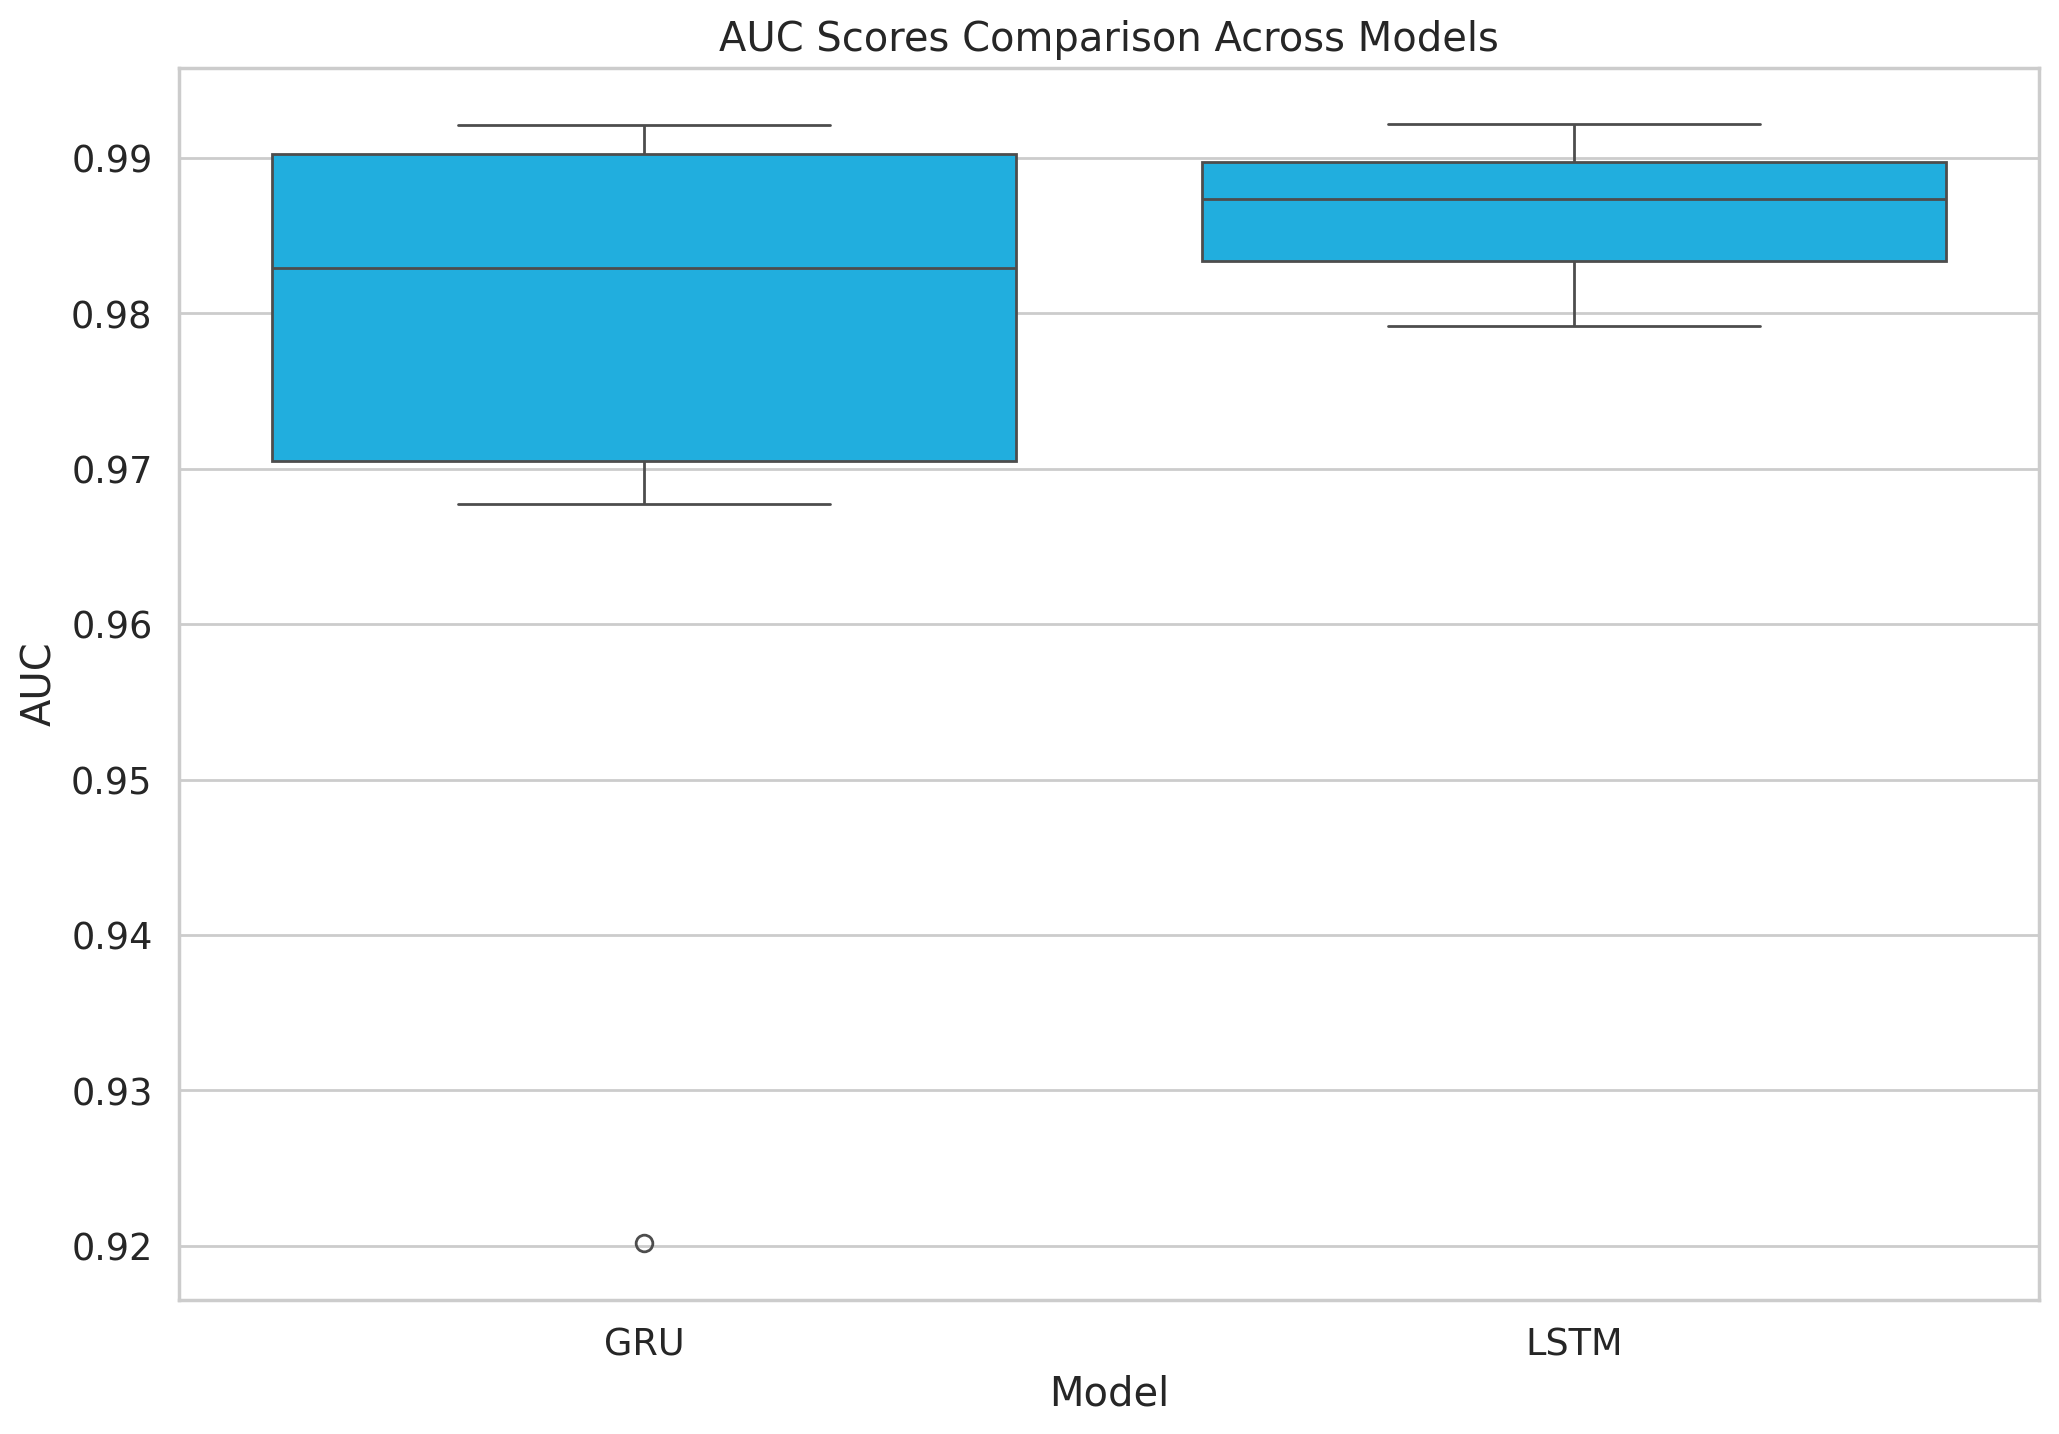

In [90]:
plot_boxplot(auc_df_2stages)

In [96]:
threshold_2stages = threshold_set(Reconstruction_Error_df_2stages)
print(Reconstruction_Error_df_2stages["GRU"][0:5])
print(threshold_2stages["GRU"])

0    11.595642
1    13.479620
2    11.083651
3    10.506943
4    13.764083
Name: GRU, dtype: float64
110.2660550965931


In [51]:
duration_3stages, auc_df_3stages, Reconstruction_Error_df_3stages = duration_auc_reError(40, 10, 3) # n_epochs, n_models, n_stages

0
1
2
3
4
5
6
7
8
9


In [52]:
print(duration_3stages)

3:02:16.887324


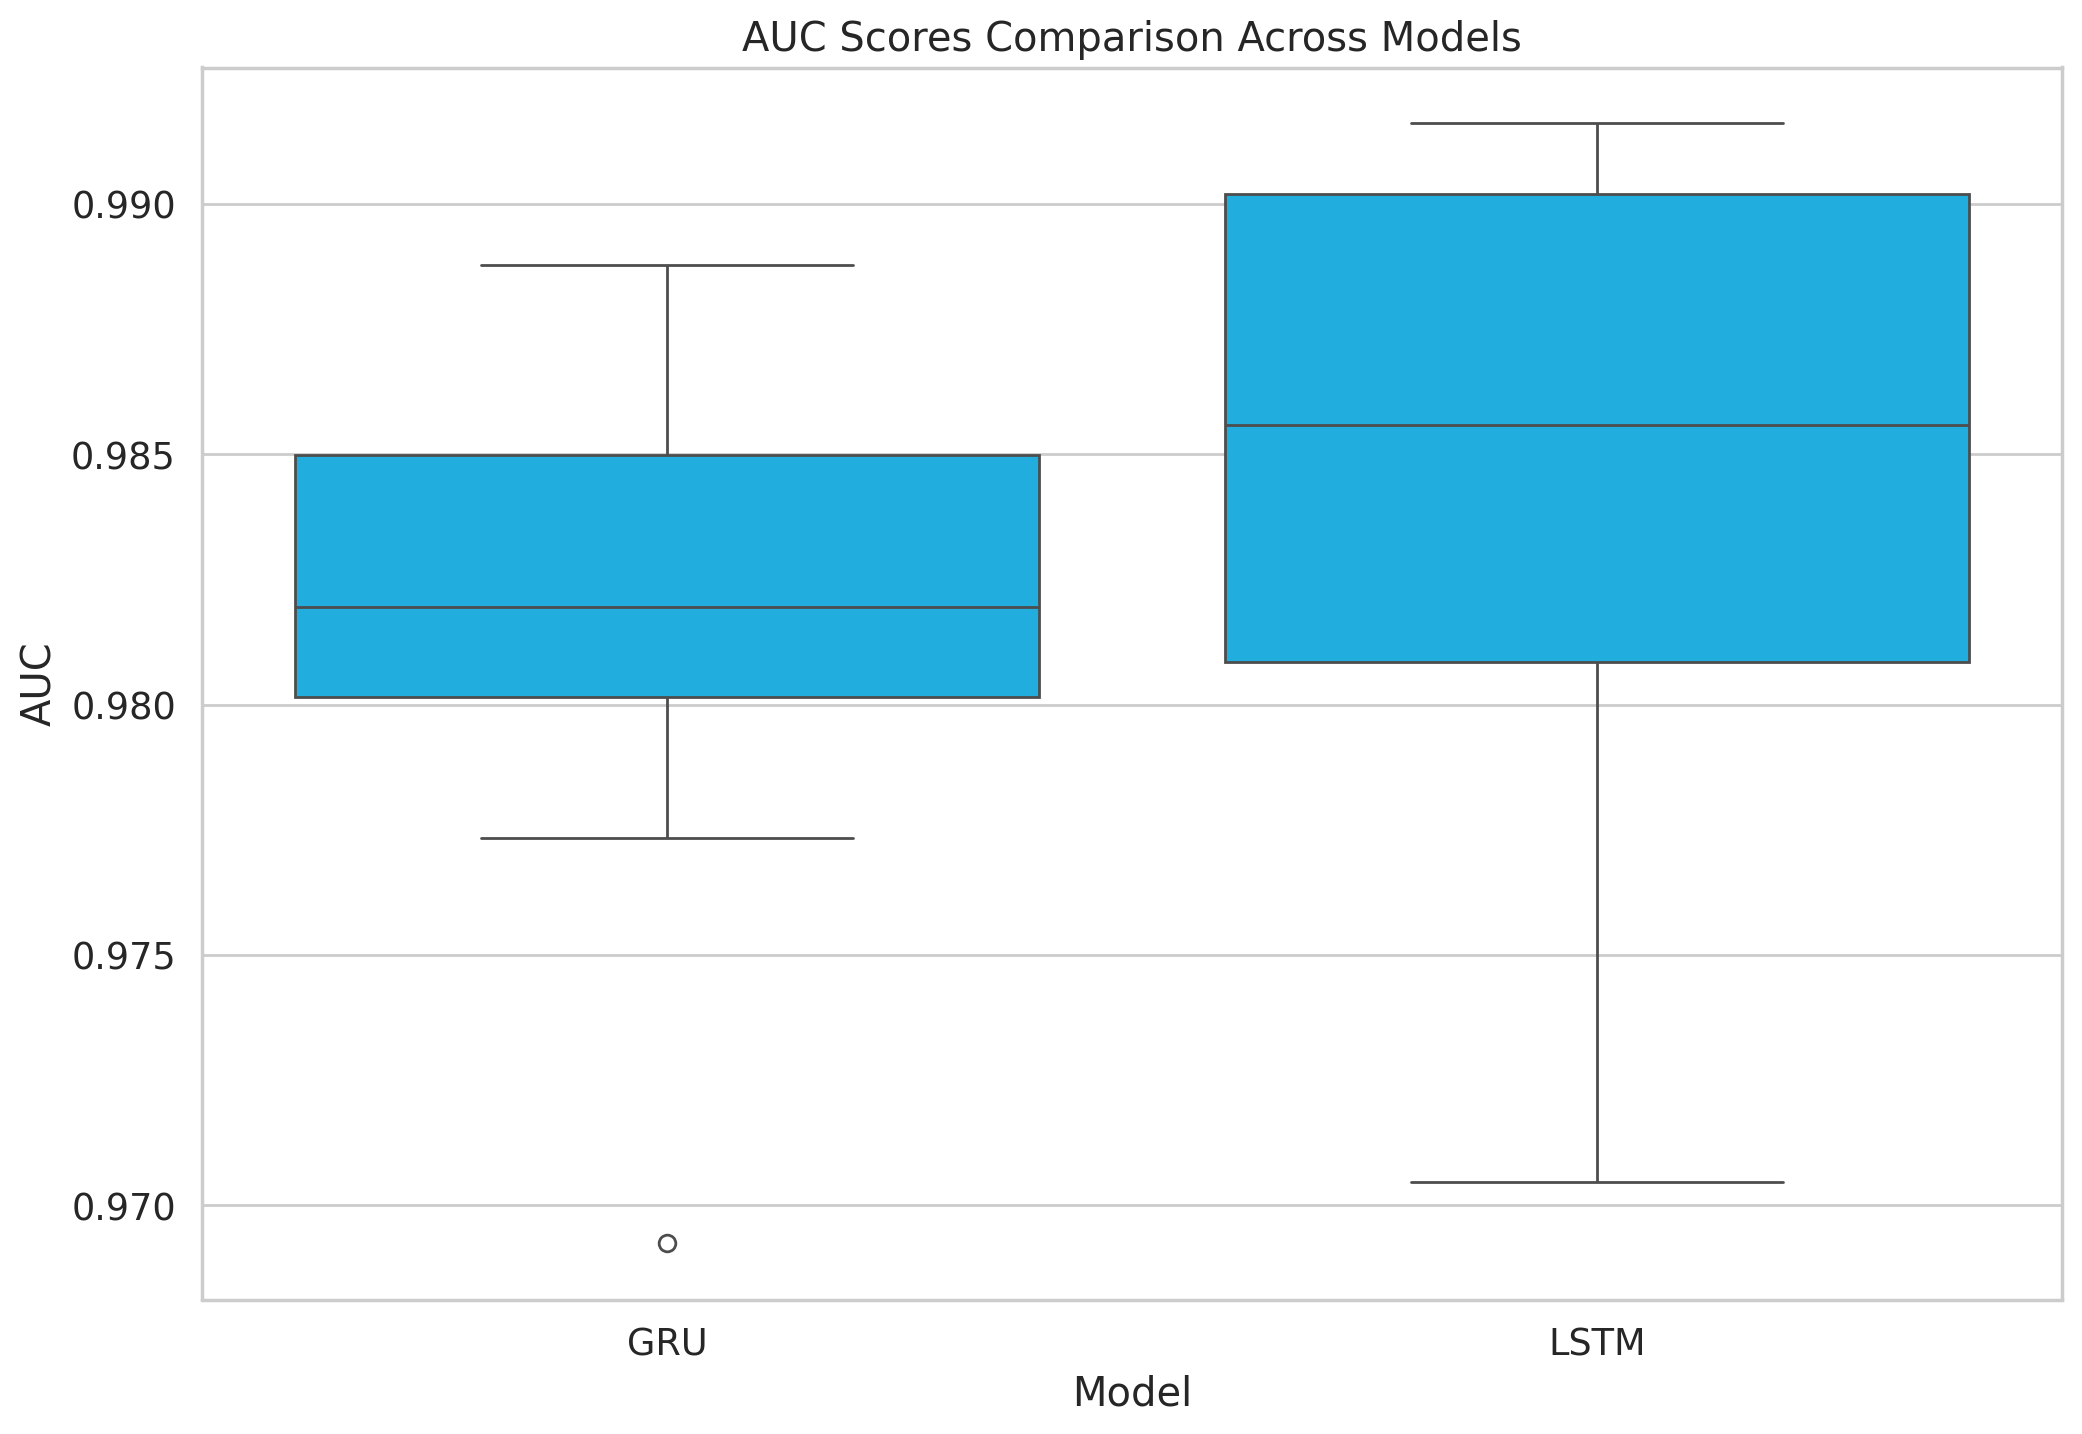

In [53]:
plot_boxplot(auc_df_3stages)

In [55]:
threshold_3stages = threshold_set(Reconstruction_Error_df_3stages)
print(Reconstruction_Error_df_3stages["GRU"][0:5])
print(threshold_3stages)


0    35.864029
1    29.499071
2    25.546741
3    26.816204
4    35.871365
Name: GRU, dtype: float64
{'GRU': np.float64(111.33167699954546), 'LSTM': np.float64(117.3360545882079)}


In [57]:
duration_4stages, auc_df_4stages, Reconstruction_Error_df_4stages = duration_auc_reError(40, 10, 4) # n_epochs, n_models, n_stages

0
1
2
3
4
5
6
7
8
9


In [58]:
print(duration_4stages)

3:03:57.900067


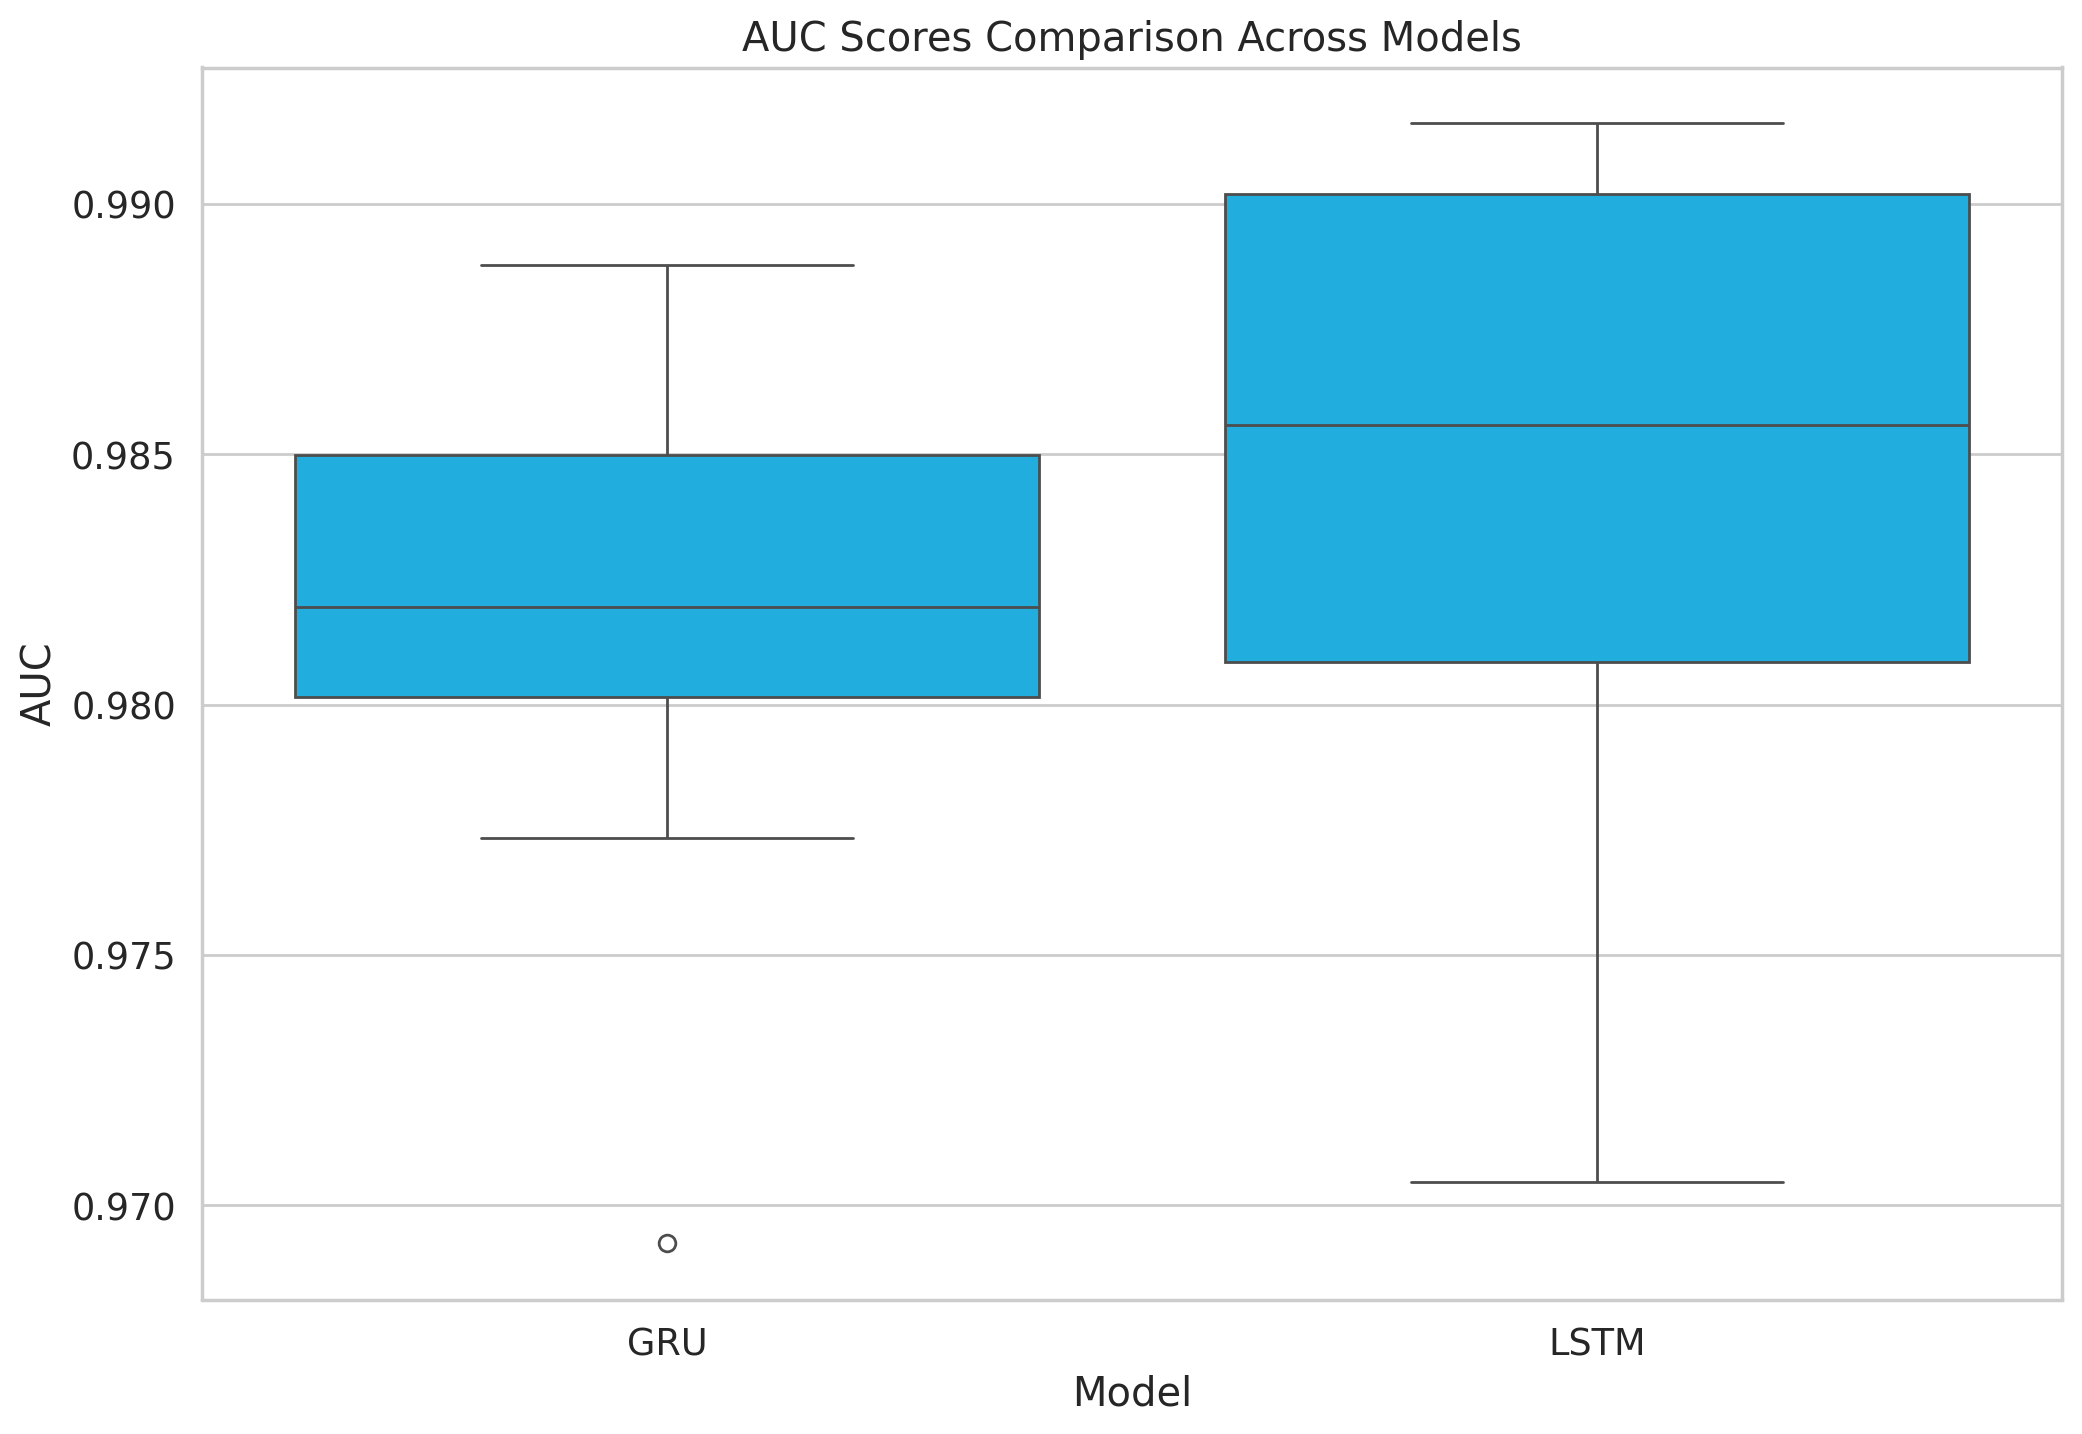

In [59]:
plot_boxplot(auc_df_4stages)

In [60]:
threshold_4stages = threshold_set(Reconstruction_Error_df_4stages)
print(Reconstruction_Error_df_4stages["GRU"][0:5])
print(threshold_4stages)


0    35.864029
1    29.499071
2    25.546741
3    26.816204
4    35.871365
Name: GRU, dtype: float64
{'GRU': np.float64(111.33167699954546), 'LSTM': np.float64(117.3360545882079)}


In [56]:
duration_2stages, auc_df_2stages, Reconstruction_Error_df_2stages = duration_auc_reError(15, 10, 2) # n_epochs, n_models, n_stages

0
1
2
3
4
5
6
7
8
9


In [57]:
print(duration_2stages)

1:13:31.244285


In [63]:
threshhold = threshold_set(Reconstruction_Error_df_2stages)
print(Reconstruction_Error_df_2stages["GRU"])
print(threshhold["GRU"])

0      38.816109
1      17.342411
2      40.693825
3      18.597225
4      22.140747
         ...    
765    56.695023
766    50.577888
767    48.952404
768    59.111362
769    57.124409
Name: GRU, Length: 770, dtype: float64
102.35792741663411


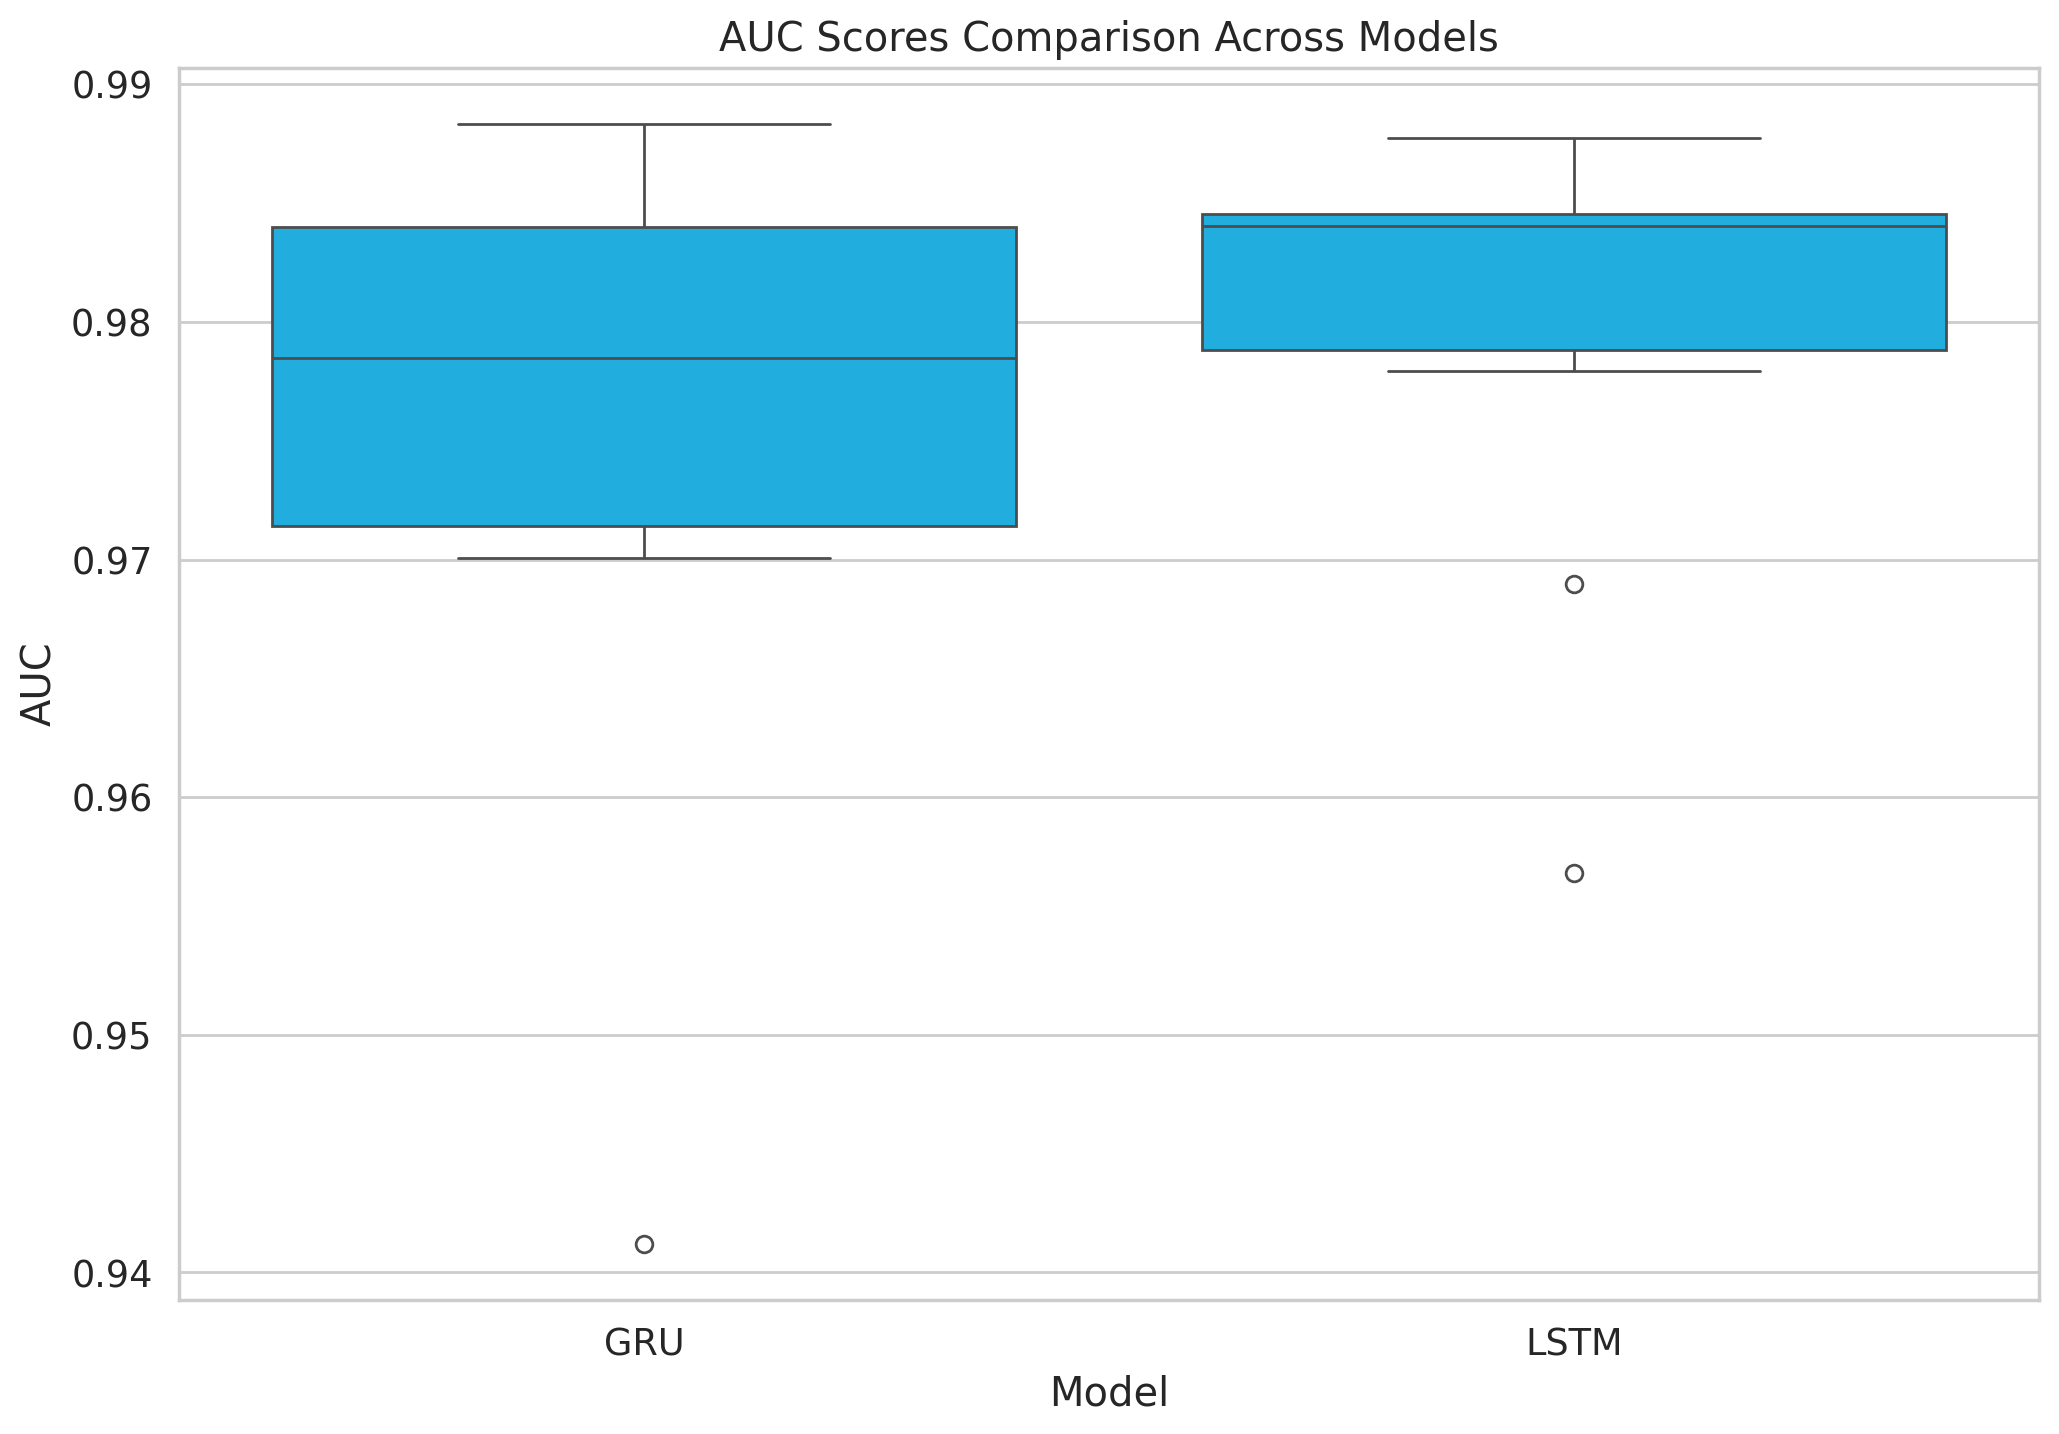

In [60]:
plot_boxplot(auc_df_2stages)

In [123]:
LSTM_model, T_dataset, T_target_df = final_model("LSTM",15,2)

In [125]:
_, pred_losses = predict(LSTM_model, T_dataset)

In [ ]:
LSTM_model_predictions = []
LSTM_model_predictions = [1 if loss > threshhold else 0 for loss in pred_losses]

In [ ]:
T_target_list = T_target_df.apply(lambda x: 0 if x == 0 else 1).tolist()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(T_target_list, LSTM_model_predictions)
precision = precision_score(T_target_list, LSTM_model_predictions)
recall = recall_score(T_target_list, LSTM_model_predictions)
f1 = f1_score(T_target_list, predictions)
conf_matrix = confusion_matrix(T_target_list, LSTM_model_predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


In [ ]:
# After training your model:
import torch

# Save model
torch.save(LSTM_model, 'trained_model.pth')



In [ ]:
# When you open the notebook again:

# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')


In [55]:
duration_3stages, auc_df_3stages, Reconstruction_Error_df_3stages = duration_auc_reError(15, 10, 3)

0
1
2
3
4
5
6
7
8
9


In [58]:
print(duration_3stages)

1:29:05.788501


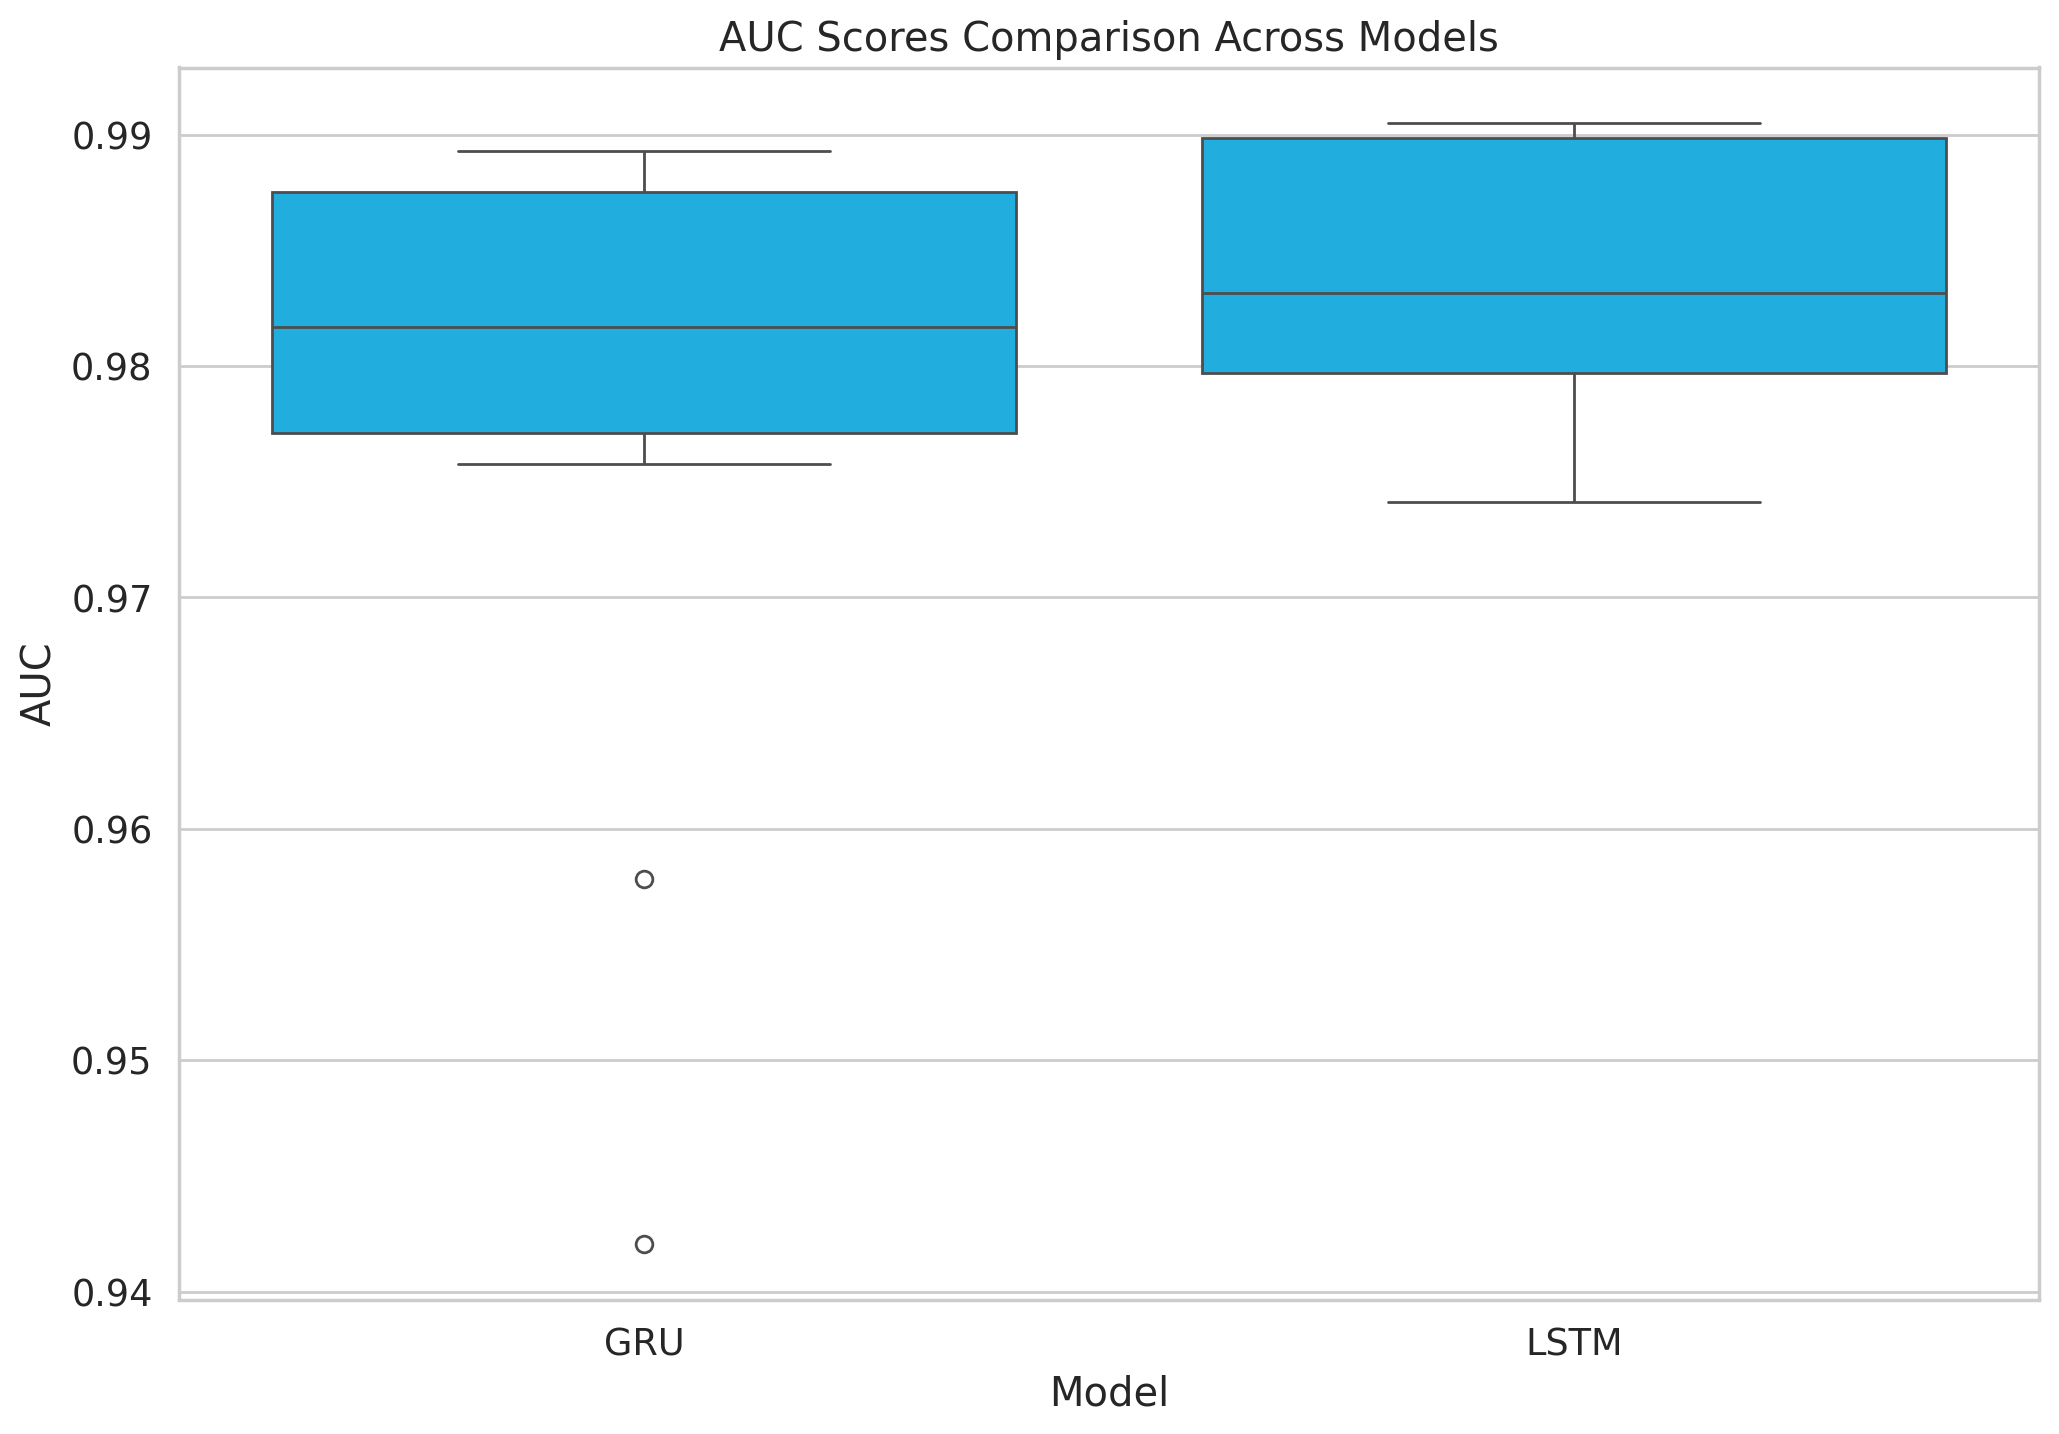

In [73]:
plot_boxplot(auc_df_3stages)

In [71]:
threshold_3stages = threshold_set(Reconstruction_Error_df_3stages)
print(Reconstruction_Error_df_3stages["GRU"])
print(threshold_3stages["GRU"])

0       22.231508
1       29.874817
2       15.846325
3       25.388739
4       19.122086
          ...    
1598    74.852066
1599    66.442581
1600    43.461998
1601    77.585892
1602    72.519722
Name: GRU, Length: 1603, dtype: float64
132.11686291577192


In [ ]:
LSTM_3stages_model, T_dataset, T_target_df = final_model("LSTM",15,2)

In [ ]:
_, pred_3stages_losses = predict(LSTM_3stages_model, T_dataset)

In [ ]:
LSTM_3stages_model_predictions = []
LSTM_3stages_model_predictions = [1 if loss > threshold_3stages else 0 for loss in pred_3stages_losses]

In [ ]:
T_target_list = T_target_df.apply(lambda x: 0 if x == 0 else 1).tolist()

In [56]:
duration_4stages, auc_df_4stages, Reconstruction_Error_df_4stages = duration_auc_reError(15, 10, 4)

0
1
2
3
4
5
6
7
8
9


In [59]:
print(duration_4stages)

1:07:08.064059


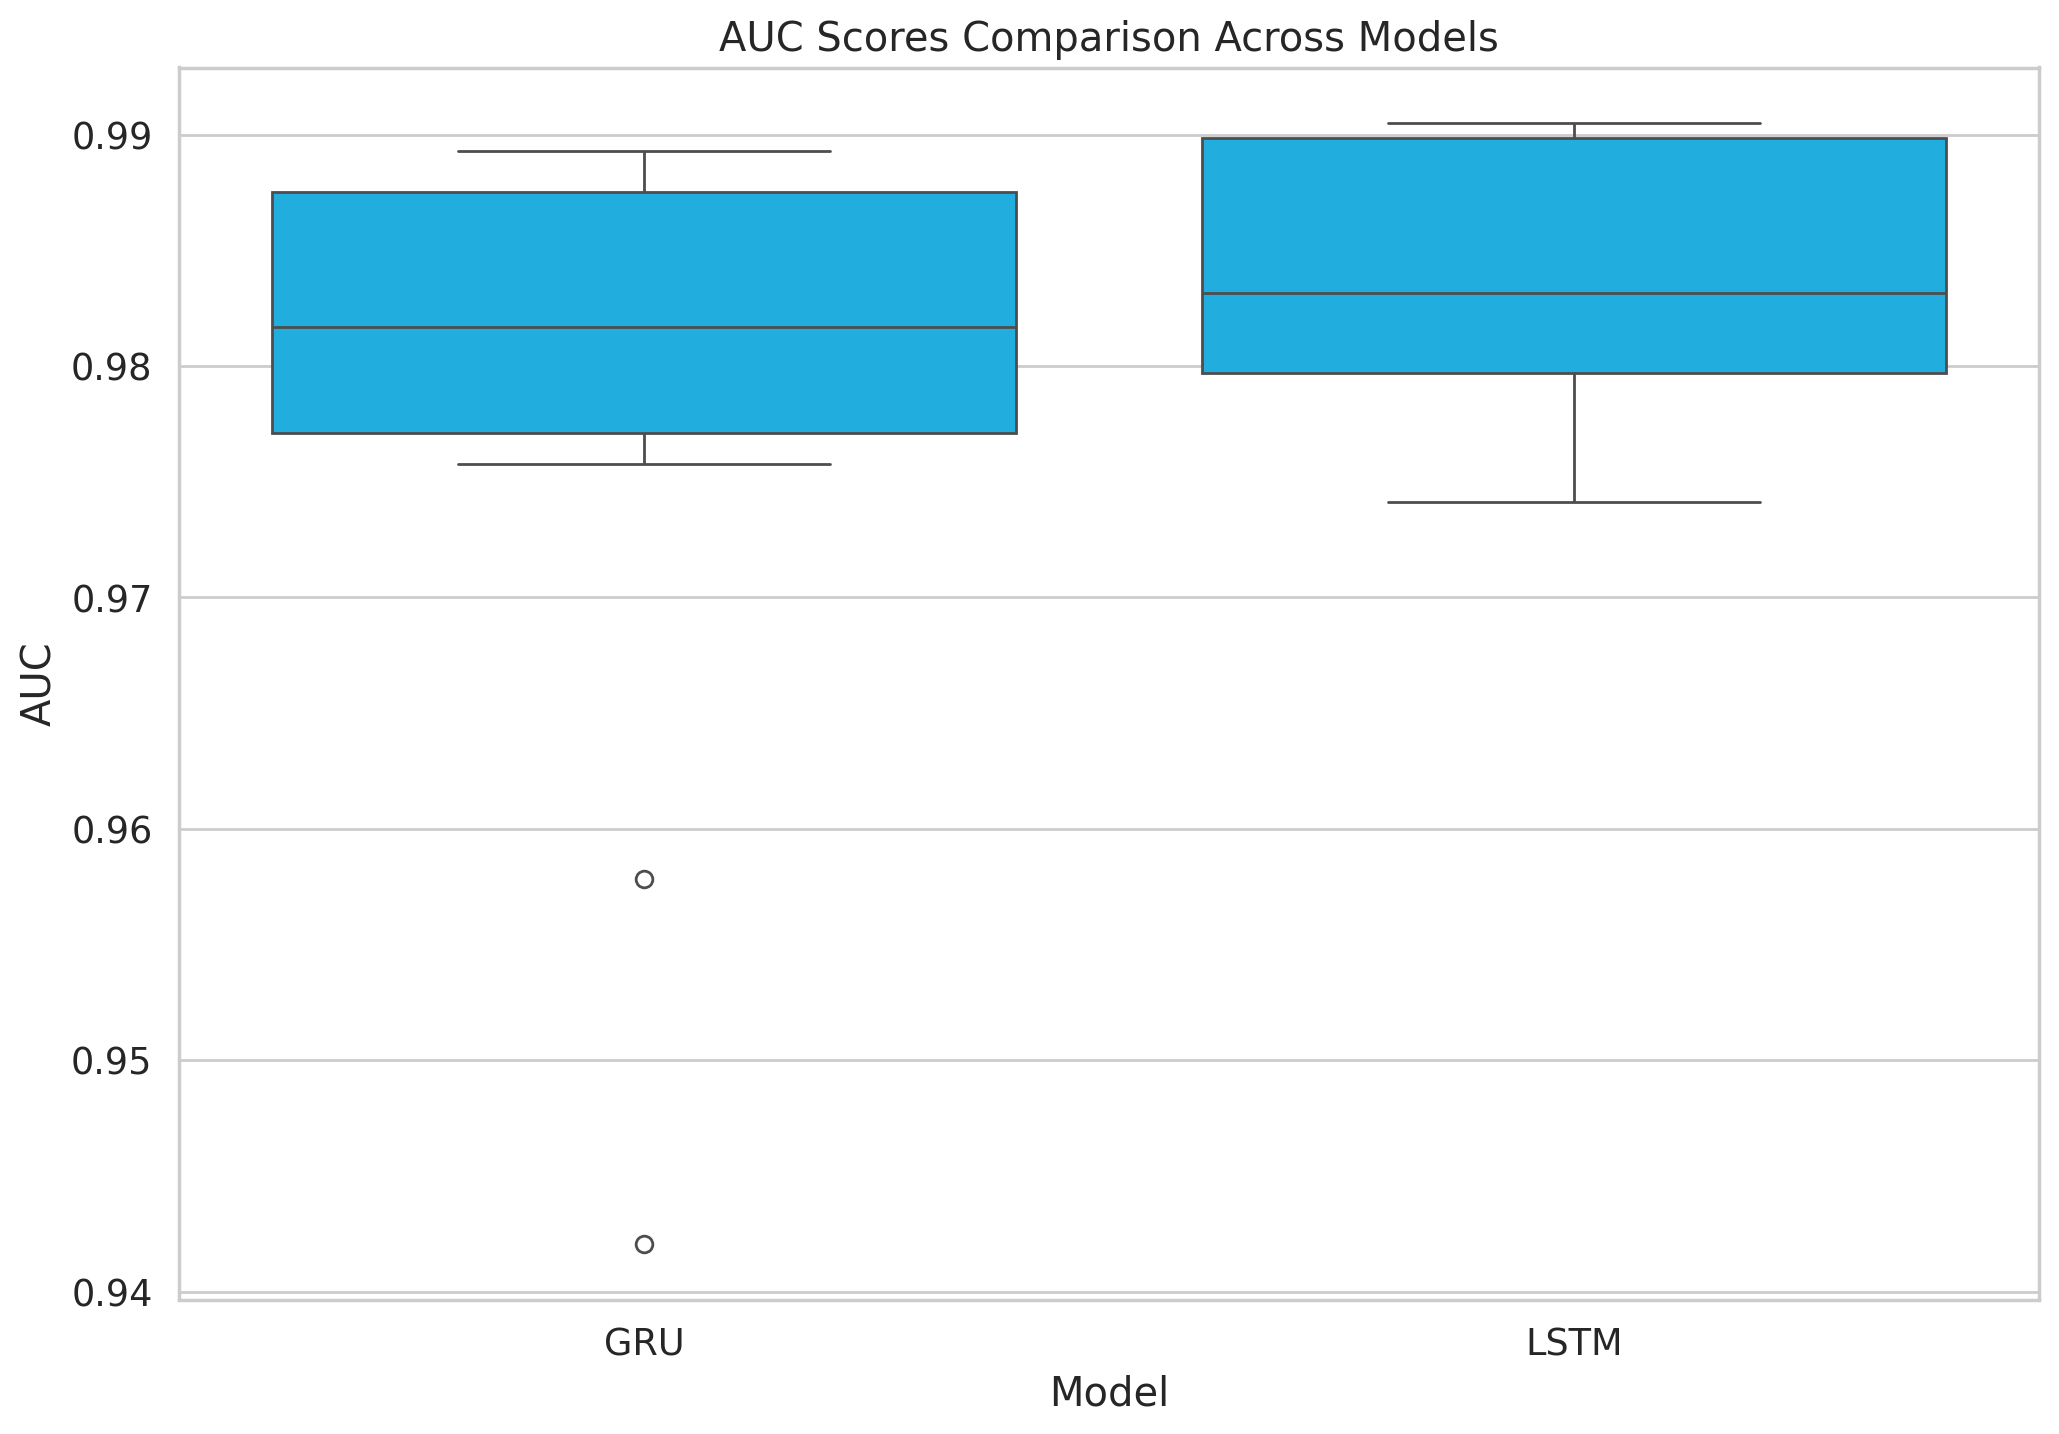

In [74]:
plot_boxplot(auc_df_4stages)

In [68]:
threshold_4stages = threshold_set(Reconstruction_Error_df_4stages)
print(Reconstruction_Error_df_4stages["GRU"])
print(threshold_4stages["GRU"])

0       22.231508
1       29.874817
2       15.846325
3       25.388739
4       19.122086
          ...    
1598    74.852066
1599    66.442581
1600    43.461998
1601    77.585892
1602    72.519722
Name: GRU, Length: 1603, dtype: float64
132.11686291577192


In [60]:
duration_5stages, auc_df_5stages, Reconstruction_Error_df_5stages = duration_auc_reError(15, 10, 5)

0
1
2
3
4
5
6
7
8
9


In [61]:
print(duration_5stages)

1:07:13.640976


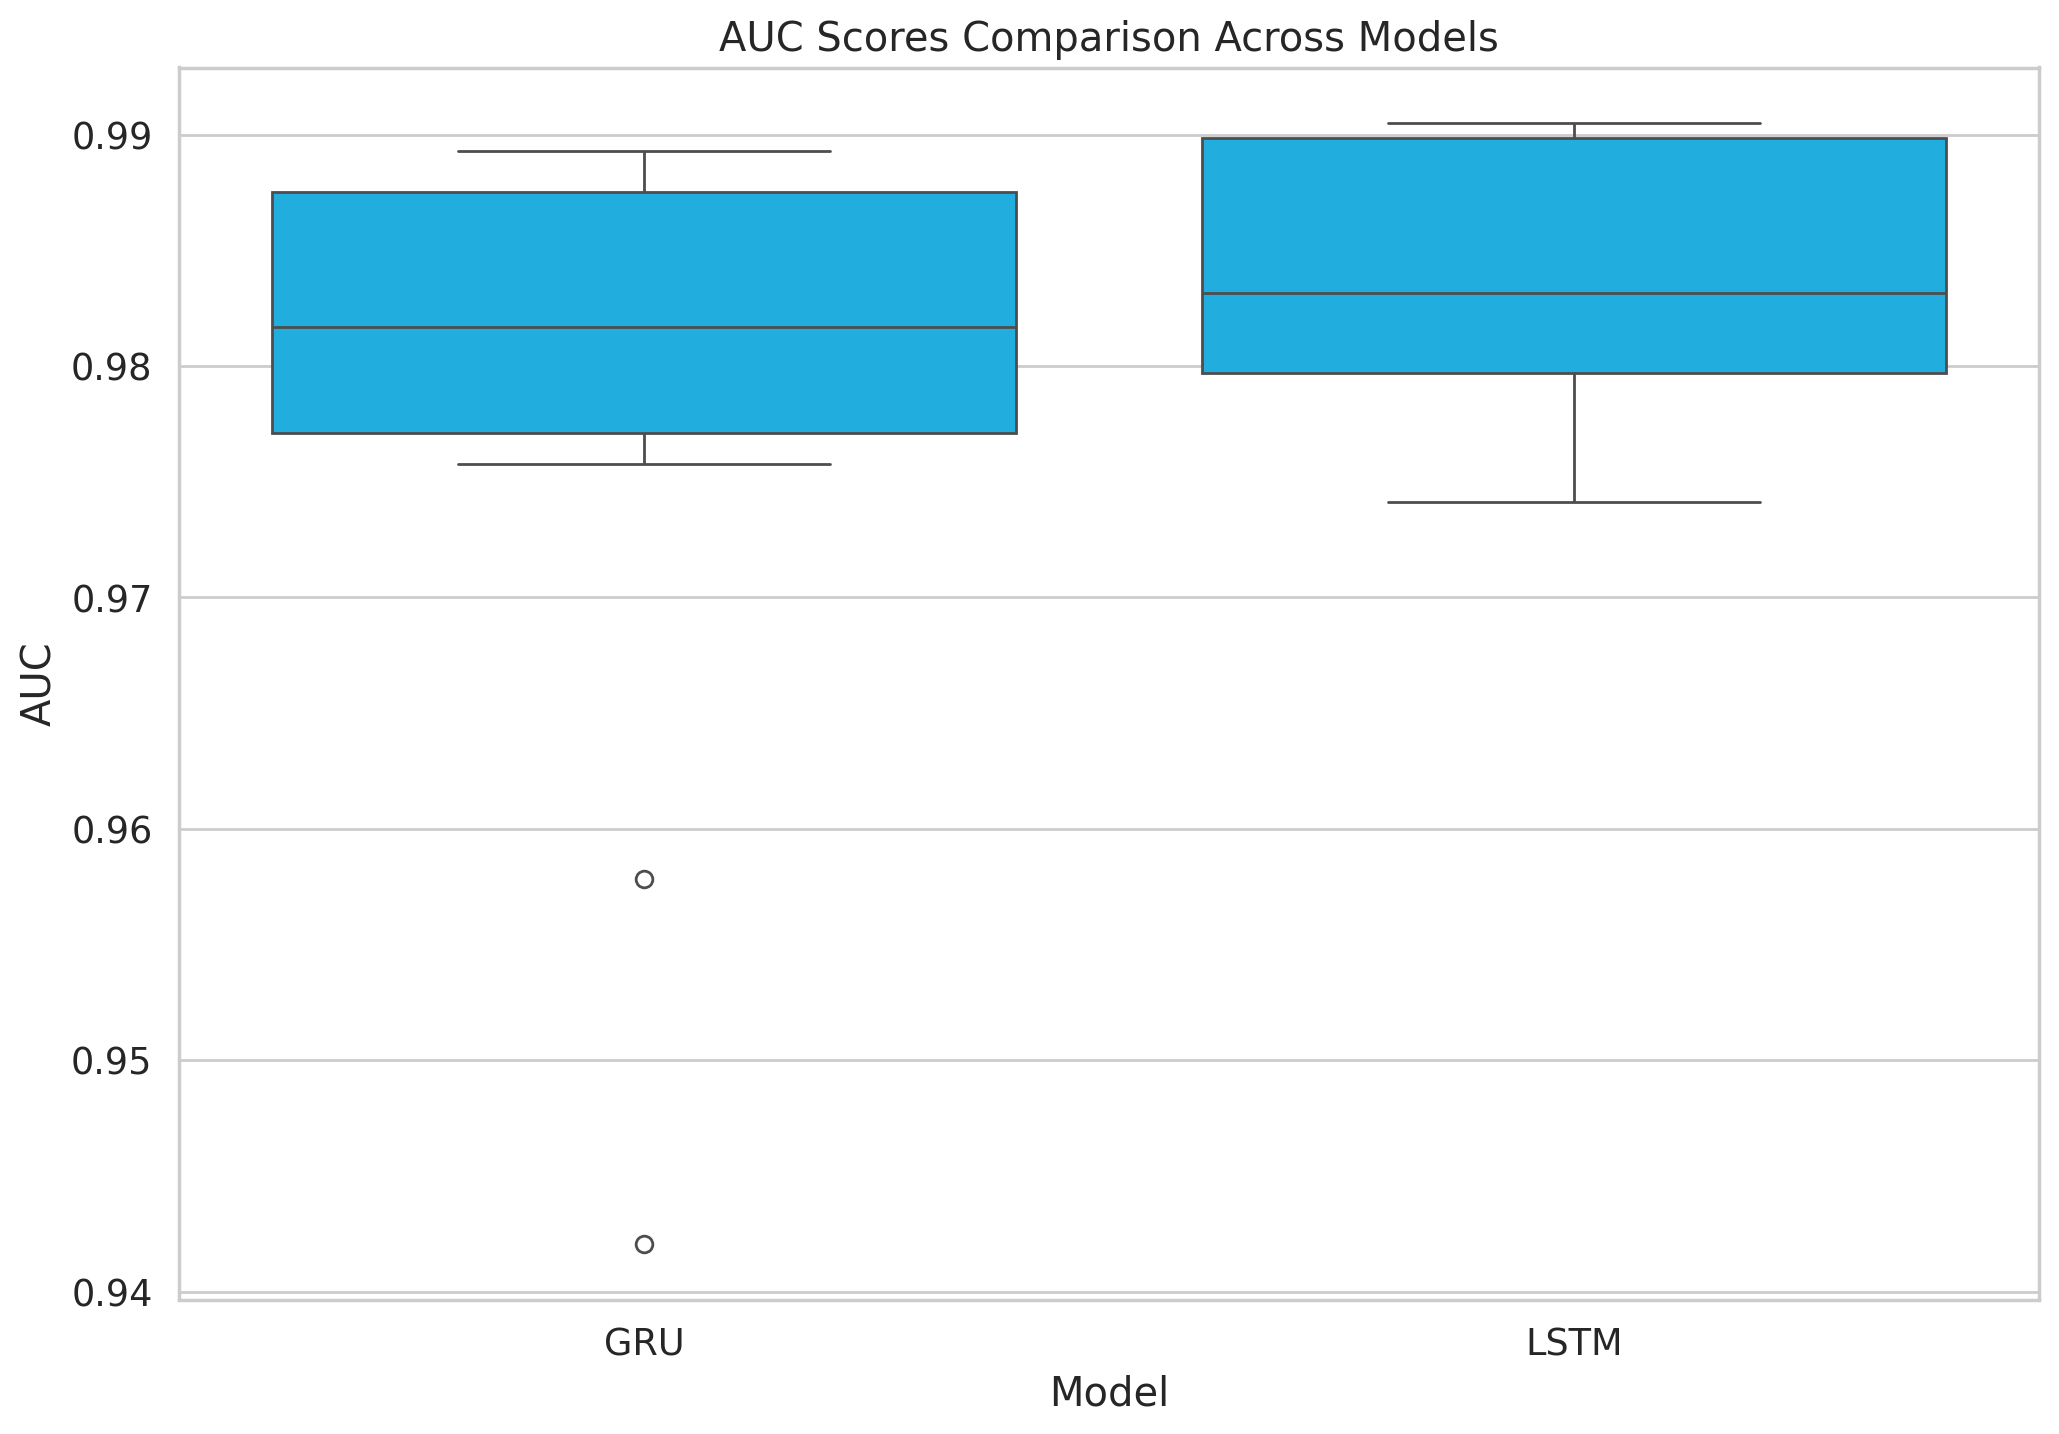

In [75]:
plot_boxplot(auc_df_5stages)

In [69]:
threshold_5stages = threshold_set(Reconstruction_Error_df_5stages)
print(Reconstruction_Error_df_5stages["GRU"])
print(threshold_5stages["GRU"])

0       22.231508
1       29.874817
2       15.846325
3       25.388739
4       19.122086
          ...    
1598    74.852066
1599    66.442581
1600    43.461998
1601    77.585892
1602    72.519722
Name: GRU, Length: 1603, dtype: float64
132.11686291577192


In [ ]:
auc_df_6stages, Reconstruction_Error_df_6stages = AUC_df(20, 20, 6)

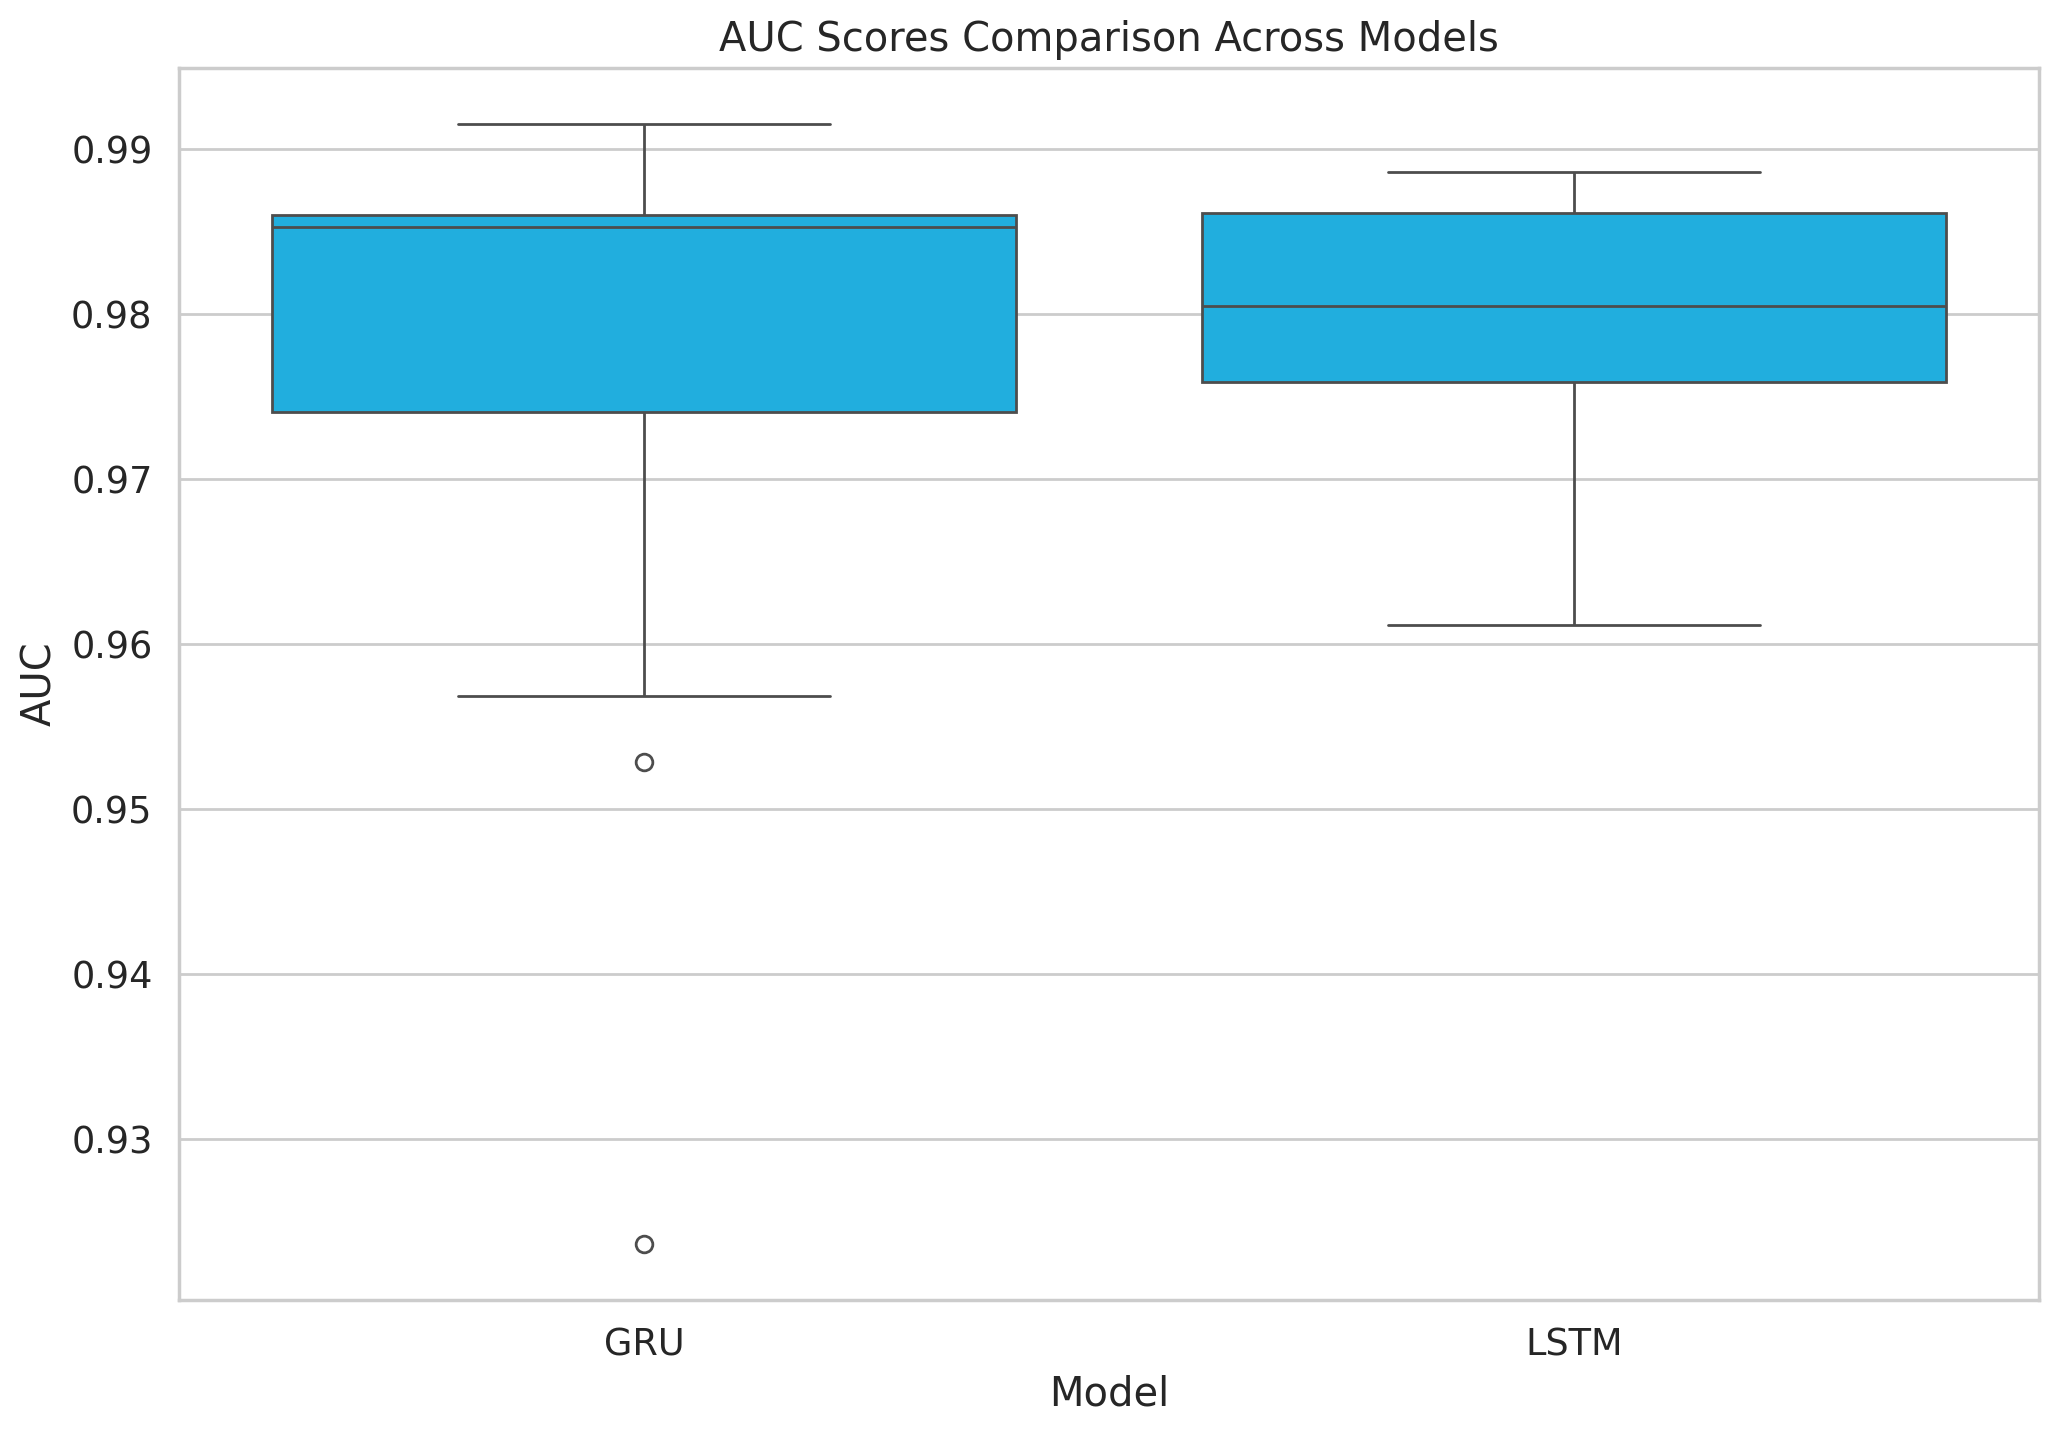

In [71]:
plot_boxplot(auc_df_2stages)

In [75]:
threshhold = threshold_set(Reconstruction_Error_df_2stages)
print(Reconstruction_Error_df_2stages["GRU"])
print(threshhold["GRU"])

0      12.280146
1      16.139673
2      17.264215
3      15.602180
4      17.076859
         ...    
765    57.619087
766    38.848663
767    56.487572
768    53.302025
769    40.271759
Name: GRU, Length: 770, dtype: float64
115.09664217667023


Create our final form of model with a random seed

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)